# DSMCER - Notebook 8: SML Model Zoo and Boosting

0. Tracking carbon
1. Linear Models
    1. Multiple Linear Regression
    2. _Exercise_: Manually compute OLS weights
    3. Logistic Regression
    4. Lasso Regression
    5. Ridge Regression
2. K-Nearest Neighbor
3. Decision Tree
    1. Random Forest
    2. _Exercise_: Cost of Random forest 
4. Kernel Methods
    1. Kernel Ridge
    2. _Poll_: Kernel Regression
    3. Support Vector Machine
    4. Gaussian Processes
5. Boosting
    1. Gradient Boosting
    2. XGBoost

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.kernel_ridge
import sklearn.gaussian_process

# ! NEW
import codecarbon
import xgboost

***
***

<font size=5><center>The goal of SML is the same regardless of architecture:

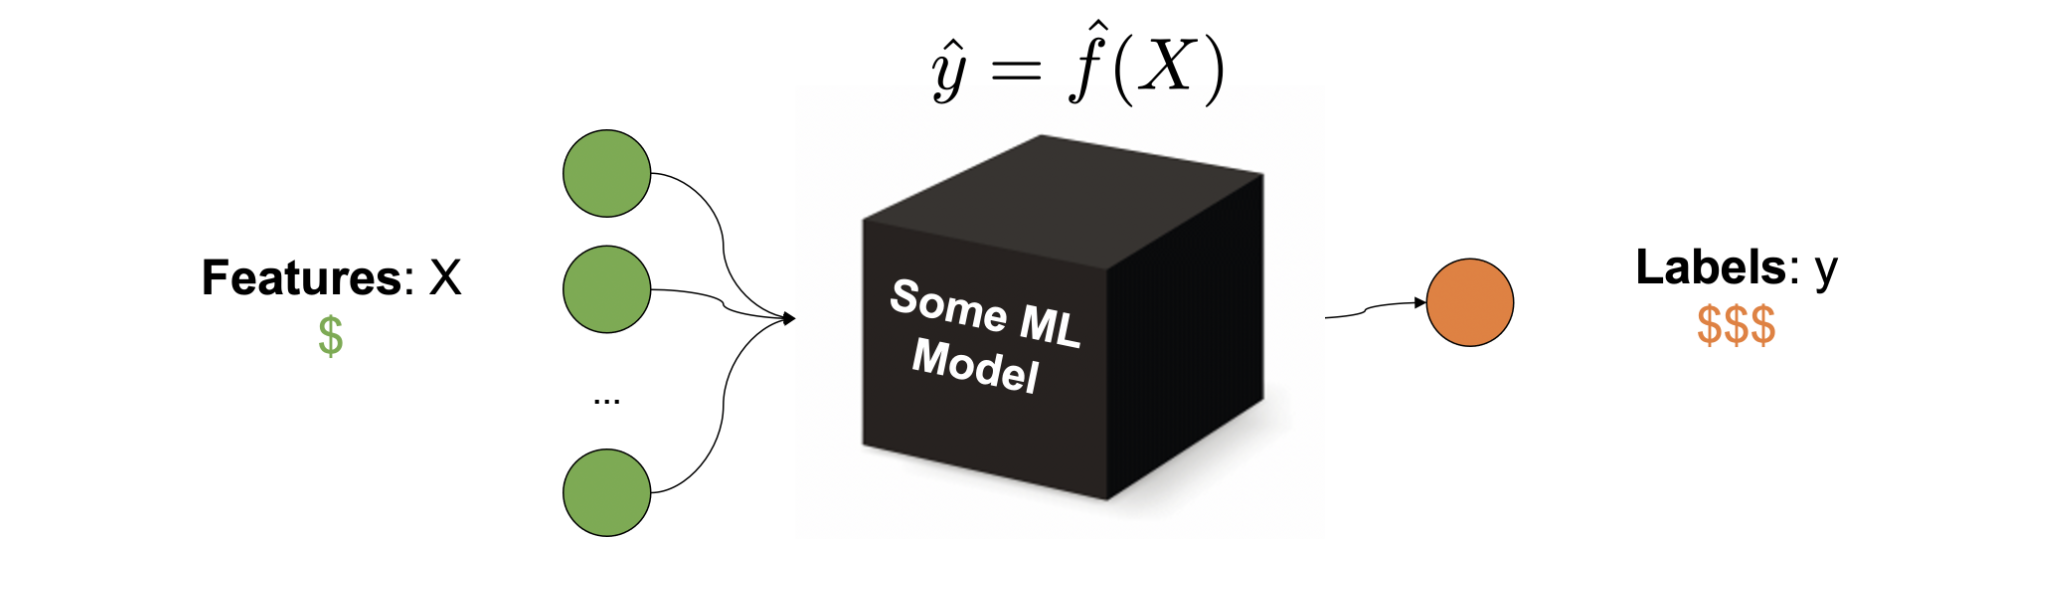

<font size=5><center>The nuance comes in developing the model ($\hat{f}$). We have to chose an architecture (hyperparameters) and train the model to determine the parameters:

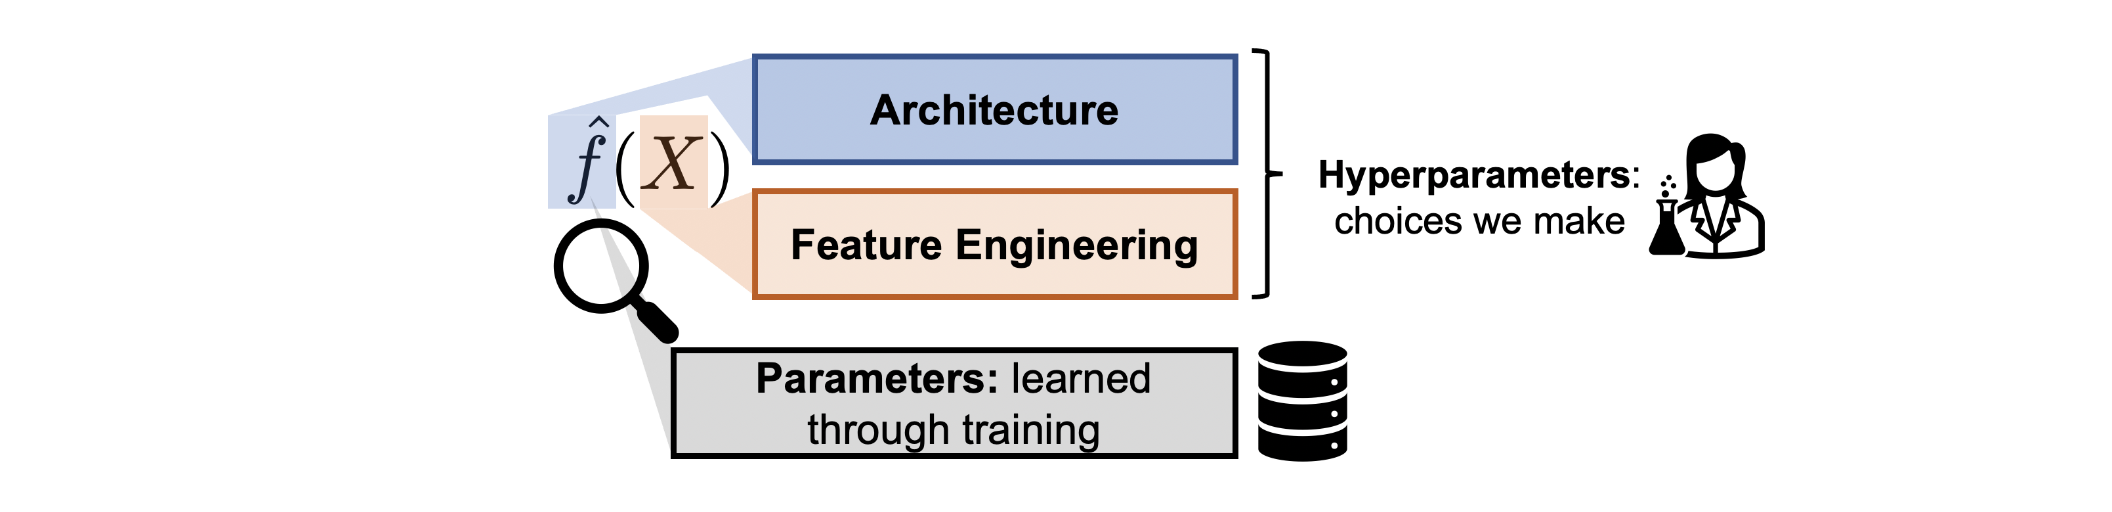

<font size=5><center>Thusfar we have only used simple models (Linear and KNN). __Its about time to introduce some more complex architectures.__

In [2]:
# load the data by downloading it
df = pd.read_csv('http://faculty.washington.edu/dacb/HCEPDB_moldata.zip').sample(5000, random_state=200)

<font size=5><center>Let's test these models on HCEPDB data, and use __all of the continuous features__ to predict LUMO to HOMO gap.

In [3]:
df['gap'] = df['e_lumo_alpha'] - df['e_homo_alpha']


In [4]:
df = df[['mass', 'pce', 'voc', 'jsc', 'gap']]

<font size=4> Let's do some basic data preprocessing

In [5]:
dev, test = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=1)

In [6]:
dev_X = dev[['mass', 'pce', 'voc', 'jsc']].values
test_X = test[['mass', 'pce', 'voc', 'jsc']].values

dev_y_regr = dev['gap'].values.reshape(-1,1)
test_y_regr = test['gap'].values.reshape(-1,1)

<font size=4> For classification - __let's choose a binary classification of the energy gap being greater than or less than 1.5__.

In [7]:
dev_y_class = dev_y_regr > 1.5
test_y_class = test_y_regr > 1.5

<font size=4> standardize features...

In [8]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.transform(test_X)

***

## 0. Tracking Carbon

<font size=4>Remember how running code takes time? __We can estimate the amount of carbon__ used with a tool called `codecarbon`. https://codecarbon.io/

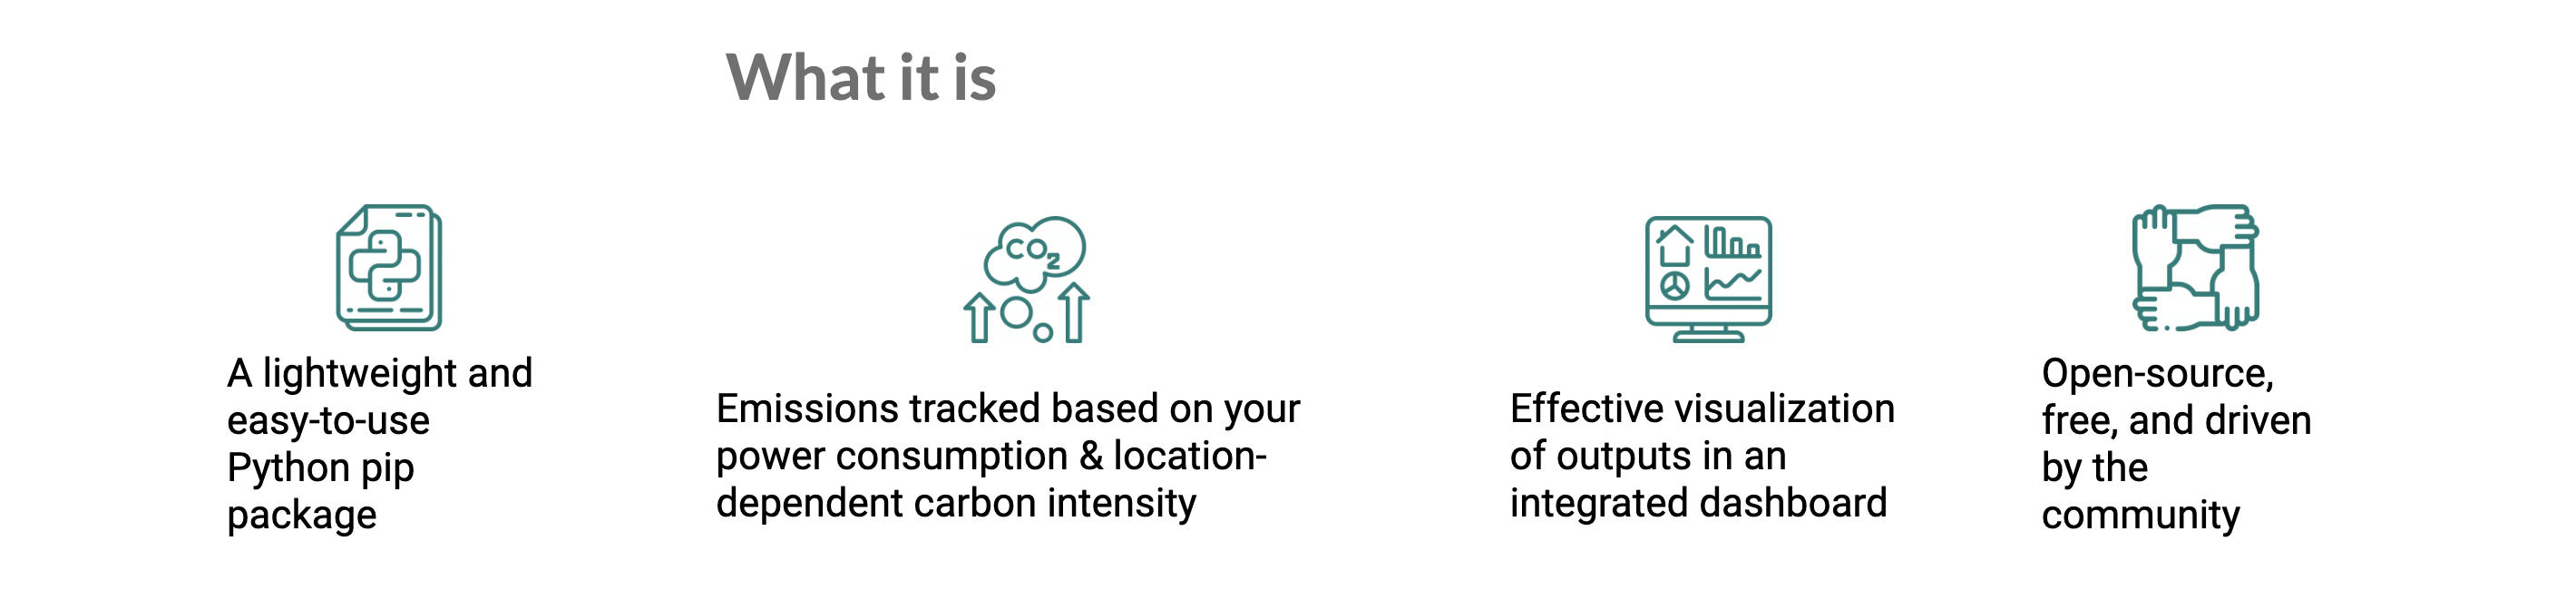

<font size=4> The tool __monitors your computer's energy usage__ and cross references with regional __carbon cost of electricity__.

In [9]:
tracker = codecarbon.EmissionsTracker()
tracker.start()
# track carbon to do computation
v1 = np.random.random((1,10000))
v2 = np.random.random((10000,1))
print(f"Vector multiplication result: {v1 @ v2}")
co2 = tracker.stop()
print(f"Carbon cost [kg]: ", co2)

[codecarbon INFO @ 10:24:04] [setup] RAM Tracking...
[codecarbon INFO @ 10:24:04] [setup] GPU Tracking...
[codecarbon INFO @ 10:24:04] No GPU found.
[codecarbon INFO @ 10:24:04] [setup] CPU Tracking...
[codecarbon WARNING @ 10:24:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:24:06] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:06] >>> Tracker's metadata:
[codecarbon INFO @ 10:24:06]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:24:06]   Python version: 3.9.15
[codecarbon INFO @ 10:24:06]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:24:06]   CPU count: 16
[codecarbon INFO @ 10:24:06]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:06]   GPU count: None
[codecarbon INFO @ 10:24:06]   GPU model: None
[codecarbon INFO @ 10:24:07] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:07] Energy consume

Vector multiplication result: [[2437.22255788]]
Carbon cost [kg]:  6.653258660686692e-09


<font size=4> Here is a function to make repeating training and testing easier!

In [10]:
def train_test_track_carbon(model, classification=False):
    tracker = codecarbon.EmissionsTracker()
    tracker.start()
    
    # train and test model
    if classification:
        metric = sklearn.metrics.accuracy_score
        dev_y = dev_y_class
        test_y = test_y_class
    else:
        metric = sklearn.metrics.mean_absolute_error
        dev_y = dev_y_regr
        test_y = test_y_regr
        
    # train model
    model.fit(dev_X, dev_y)
    
    # test the model
    preds = model.predict(test_X)
    score = metric(test_y, preds)
    co2 = tracker.stop()
    time.sleep(2)
    return score, co2

***

## 1. Linear Models 

<font size=4>One of the simplest models is to predict target using a linear combination of features:

<font size=5>$$\hat{f}(x_0, x_1,...,x_m)=b+\Sigma_{j=0}^mw_jx_j$$

- <font size=4> __Hyperparameters__: Which features $x_j$ to use.
    
- <font size=4> __Parameters__: Weights $w_j$ and bias $b$
    
- <font size=4> __Pros__: Low variance, does not require very large datasets, high intepretability
    
- <font size=4> __Cons__: High bias

### A. Multiple Linear Regression

<font size=4>Exactly described above. Regression tasks only.
    
<font size=4>[`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

<font size=4>Recall that the vector of weights is determined with matrix math. Here $X$ is the matrix of training data of shape (number of examples, number of features), and $Y$ is the column vector of example labels:

<font size=4>$$W=\begin{bmatrix}
           w_{0} \\
           w_{1} \\
           \vdots \\
           w_{m}
         \end{bmatrix} = (X^TX)^{-1}X^TY$$


<font size=4>Where $X^TX$ is called the covariance matrix.

- <font size=4> __Training of parameters__: Analytical Ordinary Least Squares

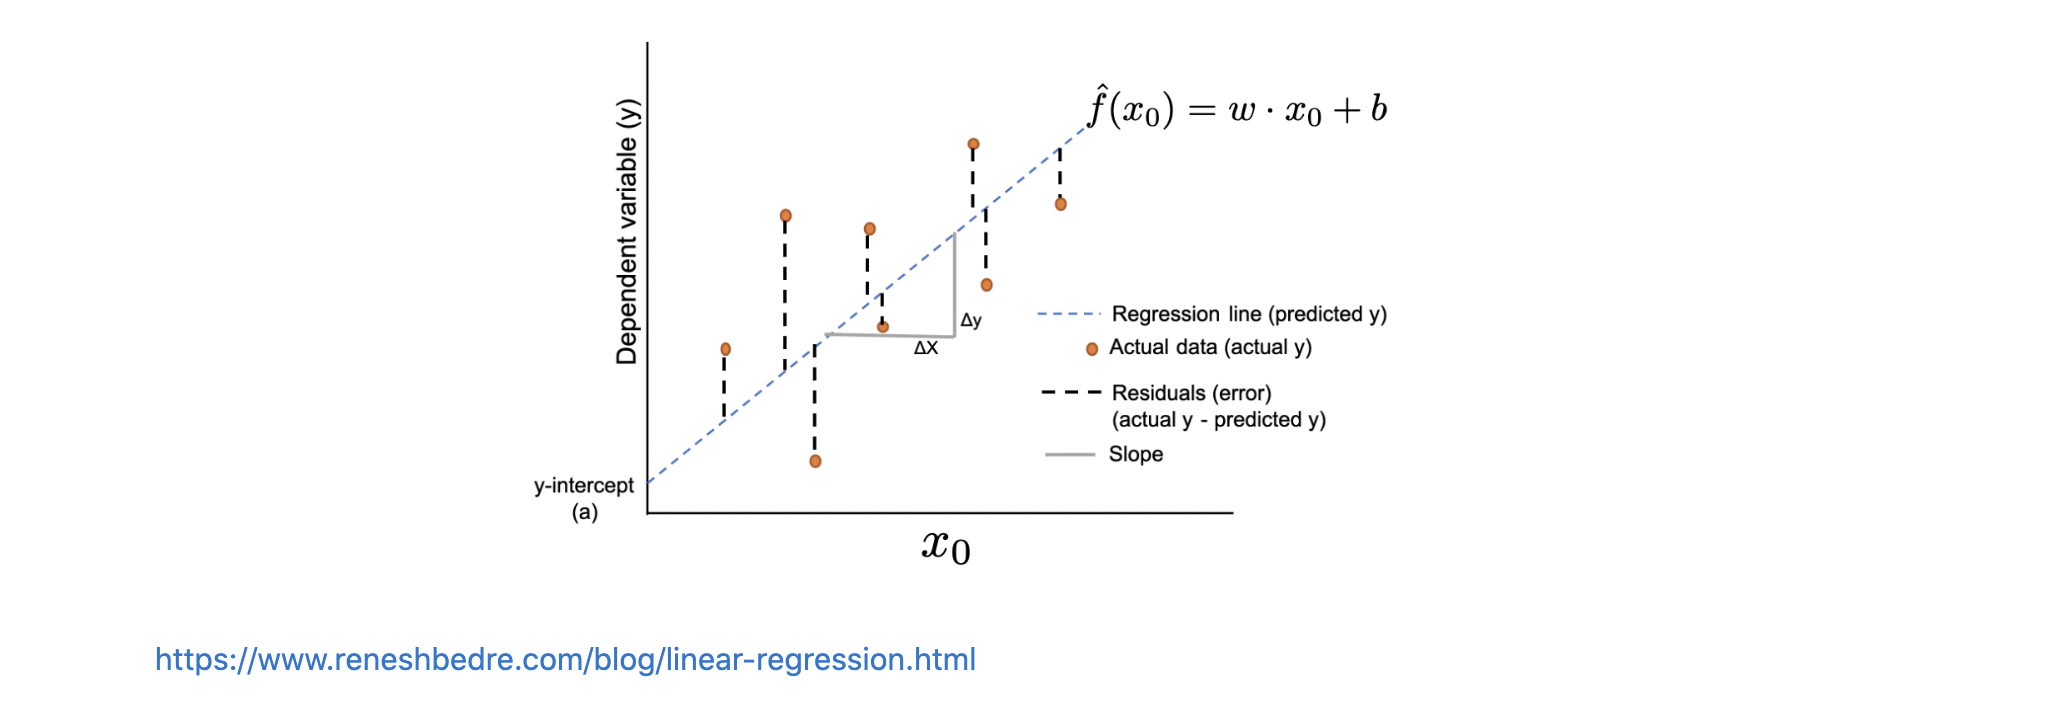

### B. _Exercise_: Manually compute OLS weights

<font size=4> Use the X and y data in the development set to manually compute the regression weights, and compare it to the weights from the multiple linear regression model in `sklearn`. *Hint: you can use `@` to multiply numpy matrices, and you can also take the inverse and transposes in numpy, have a quick google!*

In [11]:
np.linalg.inv(dev_X.T@dev_X)@dev_X.T@dev_y_regr

array([[-0.04038863],
       [-0.21530892],
       [ 0.25562472],
       [-0.12890765]])

In [12]:
model = sklearn.linear_model.LinearRegression()
model.fit(dev_X, dev_y_regr)
model.coef_

array([[-0.04038863, -0.21530892,  0.25562472, -0.12890765]])

<font size=4>They are the same!

In [13]:
model = sklearn.linear_model.LinearRegression()
score, co2 = train_test_track_carbon(model)
print(f'MAE: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 10:24:07] [setup] RAM Tracking...
[codecarbon INFO @ 10:24:07] [setup] GPU Tracking...
[codecarbon INFO @ 10:24:07] No GPU found.
[codecarbon INFO @ 10:24:07] [setup] CPU Tracking...
[codecarbon WARNING @ 10:24:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:24:08] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:08] >>> Tracker's metadata:
[codecarbon INFO @ 10:24:08]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:24:08]   Python version: 3.9.15
[codecarbon INFO @ 10:24:08]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:24:08]   CPU count: 16
[codecarbon INFO @ 10:24:08]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:08]   GPU count: None
[codecarbon INFO @ 10:24:08]   GPU model: None
[codecarbon INFO @ 10:24:08] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:08] Energy consume

MAE: 0.09331128760938846, co2 [kg]: 3.6659548421555183e-09


### C. Logistic Regression

<font size=4>Creates MLR model for each possible nominal target, and applies logistic function to the output to produce class probabilities. Classification only.
    
<font size=4>[`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

- <font size=4> __Training of parameters__: Numerical methods eg. Gradient descent (More in neural network notebook!)


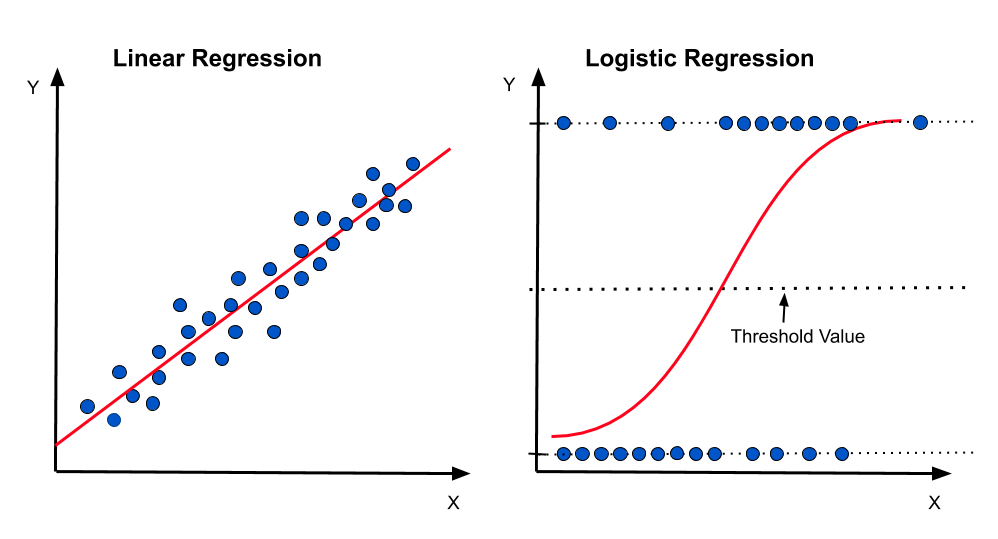

https://ai.plainenglish.io/why-is-logistic-regression-called-regression-if-it-is-a-classification-algorithm-9c2a166e7b74

In [14]:
model = sklearn.linear_model.LogisticRegression()
score, co2 = train_test_track_carbon(model, classification=True)
print(f'Accuracy: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 10:24:10] [setup] RAM Tracking...
[codecarbon INFO @ 10:24:10] [setup] GPU Tracking...
[codecarbon INFO @ 10:24:10] No GPU found.
[codecarbon INFO @ 10:24:10] [setup] CPU Tracking...
[codecarbon WARNING @ 10:24:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:24:12] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:12] >>> Tracker's metadata:
[codecarbon INFO @ 10:24:12]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:24:12]   Python version: 3.9.15
[codecarbon INFO @ 10:24:12]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:24:12]   CPU count: 16
[codecarbon INFO @ 10:24:12]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:12]   GPU count: None
[codecarbon INFO @ 10:24:12]   GPU model: None
/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: 

Accuracy: 0.9693333333333334, co2 [kg]: 2.987329356943119e-08


### D. Lasso Regression

<font size=4>Applies L1 regularization to Linear regression. Regression only. The penalty for weights using L1 regularization is the following:
    
<font size=5>$$\lambda \Sigma_j|w_j|$$

<font size=4>[`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

- <font size=4> __Training of parameters__: Analytical L1 Least Squares
    
- <font size=4> __Additional Hyperparameters__: $\lambda$ the strength of the regularization
    
- <font size=4> __Additional pros__: regularized, can be used for feature selection

In [15]:
model = sklearn.linear_model.Lasso(alpha=1.0)
score, co2 = train_test_track_carbon(model)
print(f'MAE: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 10:24:14] [setup] RAM Tracking...
[codecarbon INFO @ 10:24:14] [setup] GPU Tracking...
[codecarbon INFO @ 10:24:14] No GPU found.
[codecarbon INFO @ 10:24:14] [setup] CPU Tracking...
[codecarbon WARNING @ 10:24:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:24:15] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:15] >>> Tracker's metadata:
[codecarbon INFO @ 10:24:15]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:24:15]   Python version: 3.9.15
[codecarbon INFO @ 10:24:15]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:24:15]   CPU count: 16
[codecarbon INFO @ 10:24:15]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:15]   GPU count: None
[codecarbon INFO @ 10:24:15]   GPU model: None
[codecarbon INFO @ 10:24:15] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:15] Energy consume

MAE: 0.32789167155154764, co2 [kg]: 8.189930165194783e-09


### E. Ridge Regression

<font size=4>Applies L2 regularization to Linear regression. Regression only. The penalty for weights using L2 regularization is the following:
    
<font size=5>$$\lambda \Sigma_jw_j^2$$

<font size=4>[`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

- <font size=4> __Training of parameters__: Analytical L2 Least Squares
    
- <font size=4> __Additional Hyperparameters__: $\lambda$ the strength of the regularization
    
- <font size=4> __Additional pros__: regularized, can be used for feature selection

In [16]:
model = sklearn.linear_model.Ridge(alpha=1.0)
score, co2 = train_test_track_carbon(model)
print(f'MAE: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 10:24:17] [setup] RAM Tracking...
[codecarbon INFO @ 10:24:17] [setup] GPU Tracking...
[codecarbon INFO @ 10:24:17] No GPU found.
[codecarbon INFO @ 10:24:17] [setup] CPU Tracking...
[codecarbon WARNING @ 10:24:17] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:24:18] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:18] >>> Tracker's metadata:
[codecarbon INFO @ 10:24:18]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:24:18]   Python version: 3.9.15
[codecarbon INFO @ 10:24:18]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:24:18]   CPU count: 16
[codecarbon INFO @ 10:24:18]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:18]   GPU count: None
[codecarbon INFO @ 10:24:18]   GPU model: None
[codecarbon INFO @ 10:24:18] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:18] Energy consume

MAE: 0.09329142252786839, co2 [kg]: 1.4053886318062374e-08


## 2. K-Nearest Neighbor

<font size=4>Determines target by averaging over the target values of the nearest K training datpoints in feature space.

<font size=4>[`sklearn.neighbors.KNeighborClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
    
<font size=4>[`sklearn.neighbors.KNeighborRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor)

- <font size=4> __Hyperparameters__: Features used, Number of Neighbors, type of distance (eg euclidean)
    
- <font size=4> __Parameters__: Training data
    
- <font size=4> __Pros__: No assumptions of functional form, intuitive
    
- <font size=4> __Cons__: Does not scale well with number of datapoints and number of features

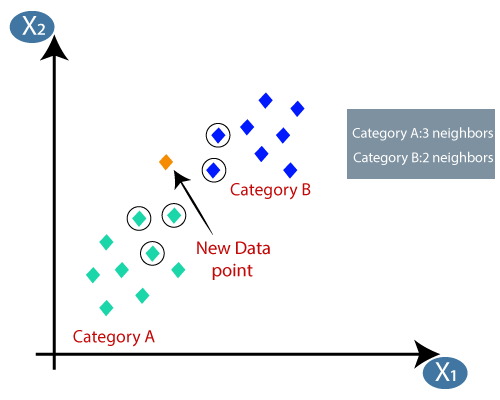

https://www.javatpoint.com/k-nearest-neighbor-algorithm-for-machine-learning

In [17]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10)
score, co2 = train_test_track_carbon(model, classification=True)
print(f'Accuracy: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 10:24:20] [setup] RAM Tracking...
[codecarbon INFO @ 10:24:20] [setup] GPU Tracking...
[codecarbon INFO @ 10:24:20] No GPU found.
[codecarbon INFO @ 10:24:20] [setup] CPU Tracking...
[codecarbon WARNING @ 10:24:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:24:22] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:22] >>> Tracker's metadata:
[codecarbon INFO @ 10:24:22]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:24:22]   Python version: 3.9.15
[codecarbon INFO @ 10:24:22]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:24:22]   CPU count: 16
[codecarbon INFO @ 10:24:22]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:22]   GPU count: None
[codecarbon INFO @ 10:24:22]   GPU model: None
/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionW

Accuracy: 0.984, co2 [kg]: 3.541786521994552e-08


## 3. Decision Trees

<font size=4>Sequentially partitions data based on feature thresholds, chosing thresholds to maximally seperate the data. Effective for classification and regression.

<font size=4>[`sklearn.tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
    
<font size=4>[`sklearn.tree.DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)

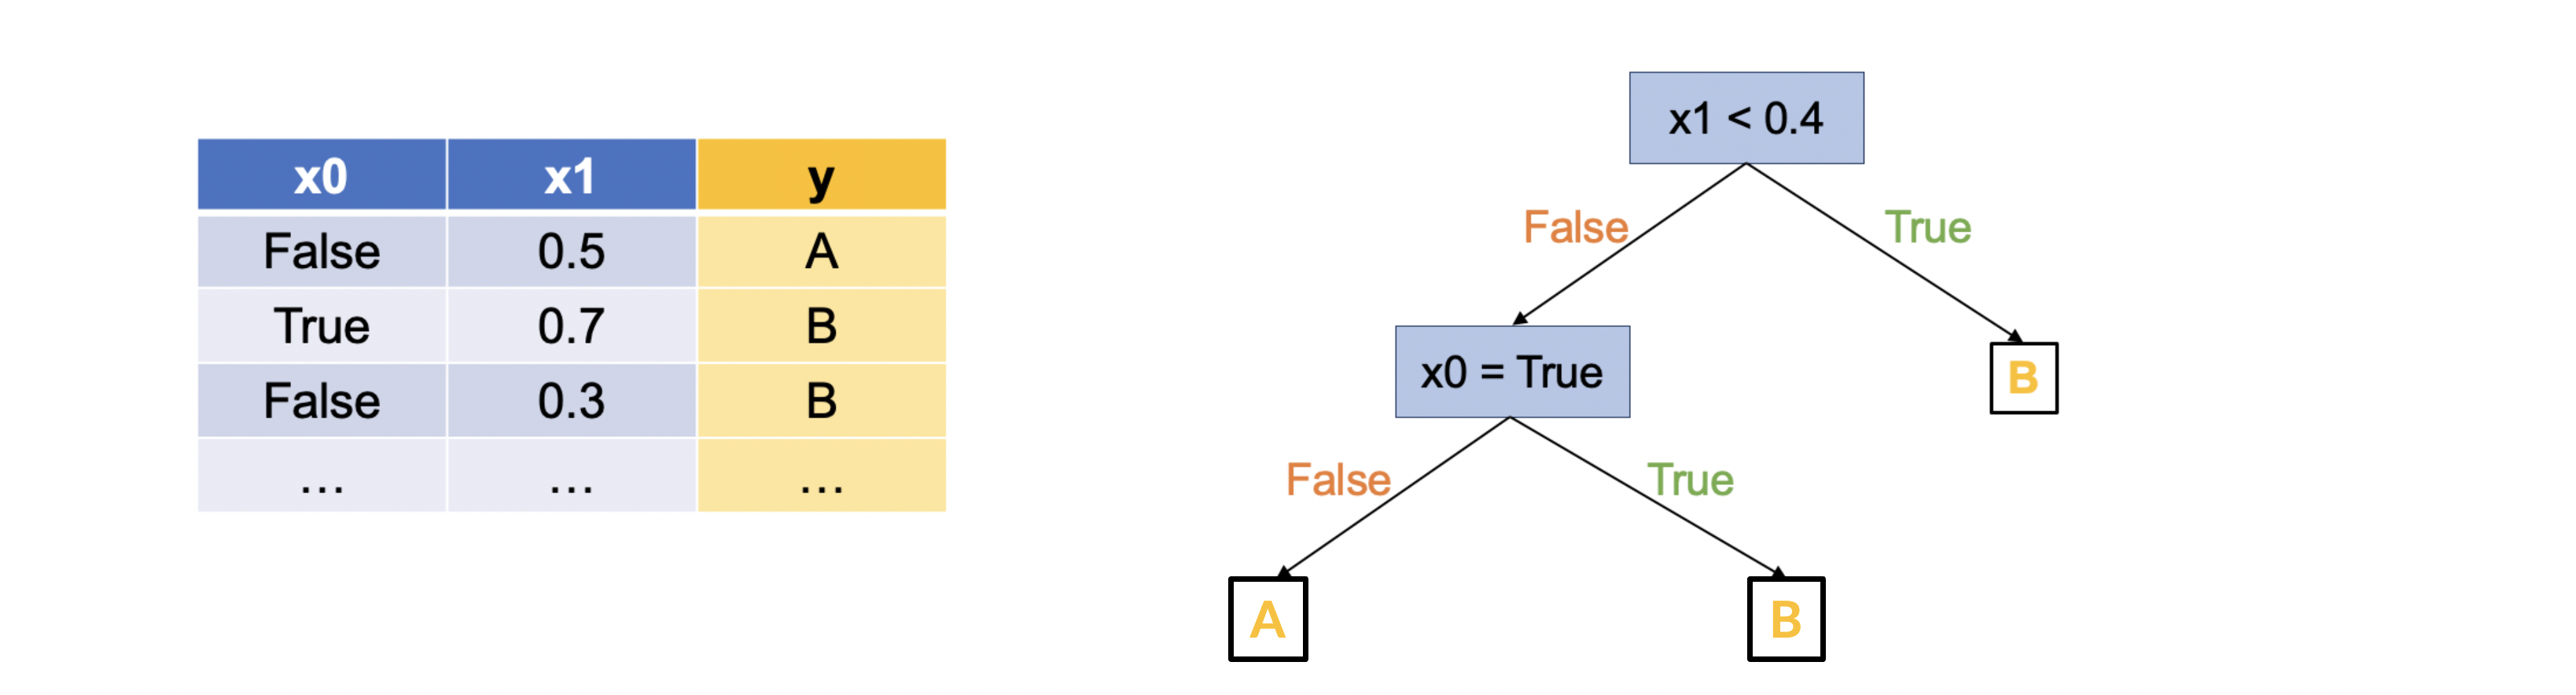

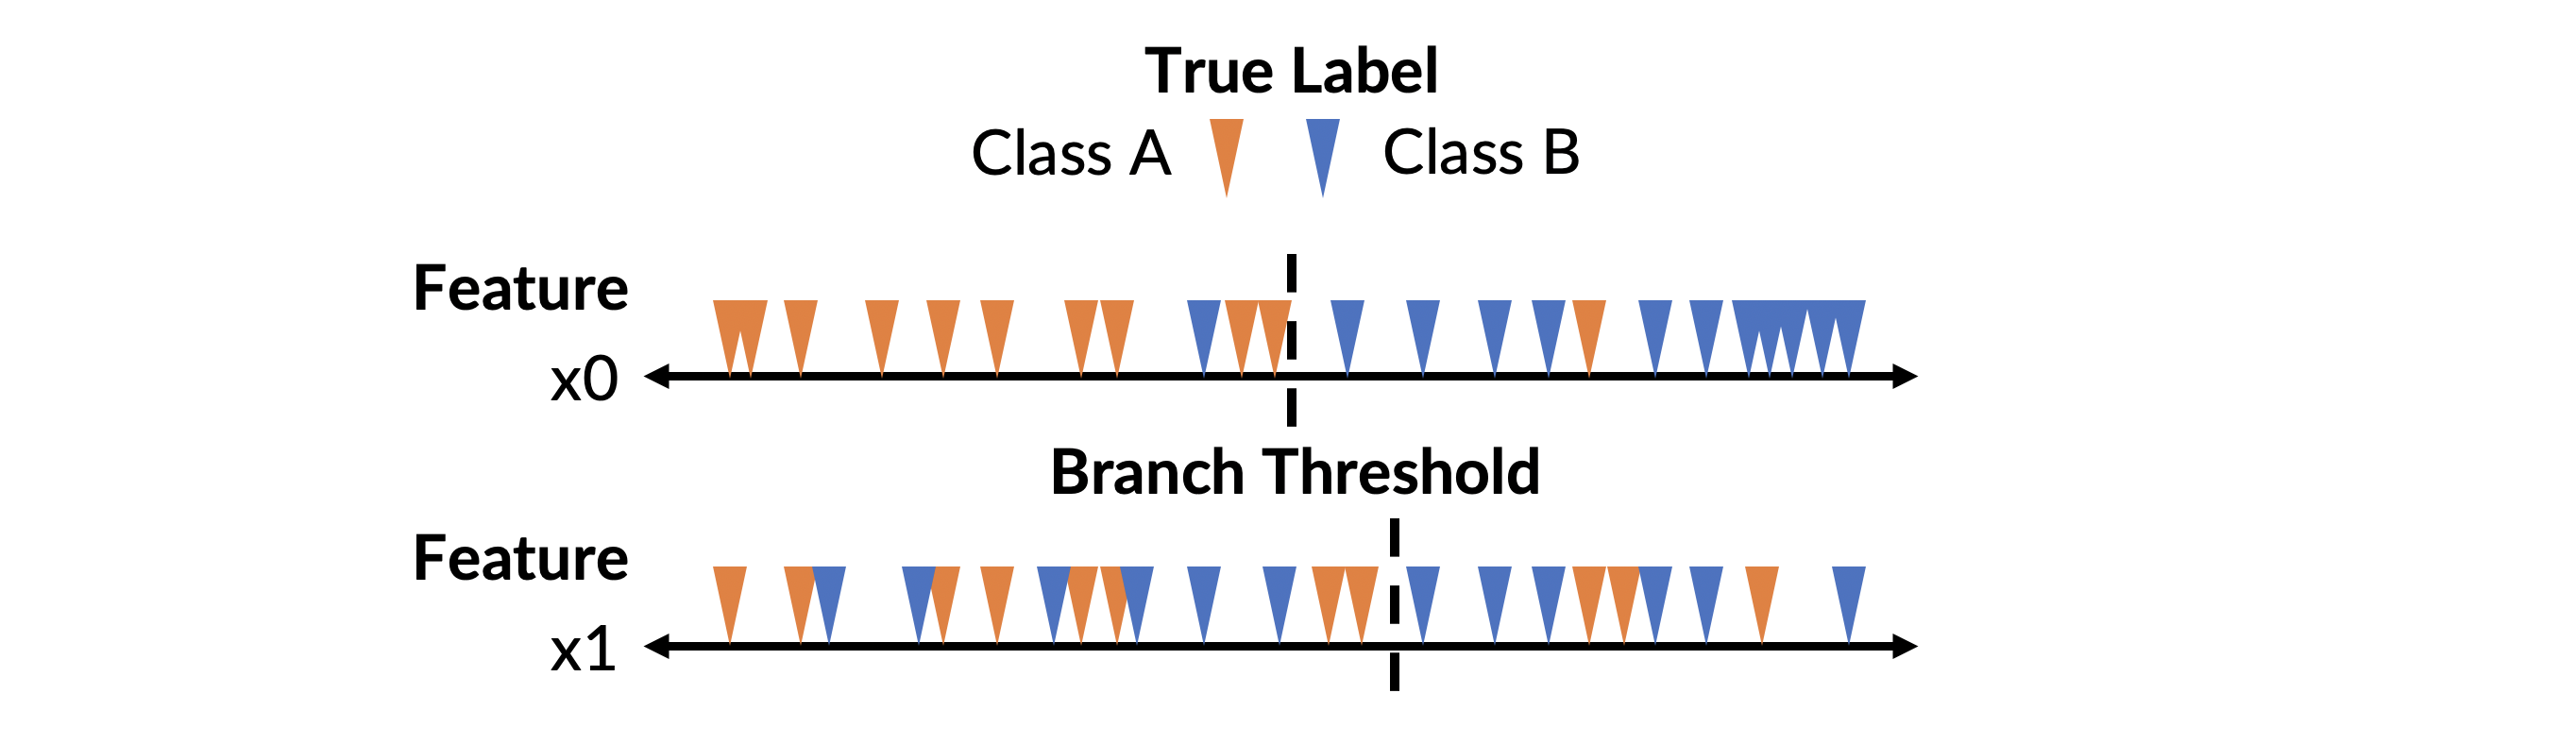

<font size=4> __Branches are chosen using a subset of feature/s to maximally seperate the data__. In the example above, using $x0$ is better than useing $x1$. __The data on either side of the threshold moves on to different parts of the tree__. Features can be reused at different branches as the data subset gets smaller and smaller.

- <font size=4> __Hyperparameters__: Features used, depth of tree, factors affecting leaf and branch decisionmaking such as minimum number of training examples on each side of a decision, seperation metric
    
- <font size=4> __Training__: Maximal seperation
    
- <font size=4> __Parameters__: Branch and leaf thresholds
    
- <font size=4> __Pros__: Intuitive and very flexible
    
- <font size=4> __Cons__: Very prone to overfitting

In [18]:
model = sklearn.tree.DecisionTreeClassifier()
score, co2 = train_test_track_carbon(model, classification=True)
print(f'Accuracy: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 10:24:24] [setup] RAM Tracking...
[codecarbon INFO @ 10:24:24] [setup] GPU Tracking...
[codecarbon INFO @ 10:24:24] No GPU found.
[codecarbon INFO @ 10:24:24] [setup] CPU Tracking...
[codecarbon WARNING @ 10:24:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:24:25] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:25] >>> Tracker's metadata:
[codecarbon INFO @ 10:24:25]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:24:25]   Python version: 3.9.15
[codecarbon INFO @ 10:24:25]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:24:25]   CPU count: 16
[codecarbon INFO @ 10:24:25]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:25]   GPU count: None
[codecarbon INFO @ 10:24:25]   GPU model: None
[codecarbon INFO @ 10:24:25] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:24:25] Energy consume

Accuracy: 0.988, co2 [kg]: 1.4669867201340943e-08


### B. Random Forest

<font size=4>Bags __data and features__ to create many decision trees. Use as an ensemble.

<font size=4>[`sklearn.tree.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
    
<font size=4>[`sklearn.tree.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

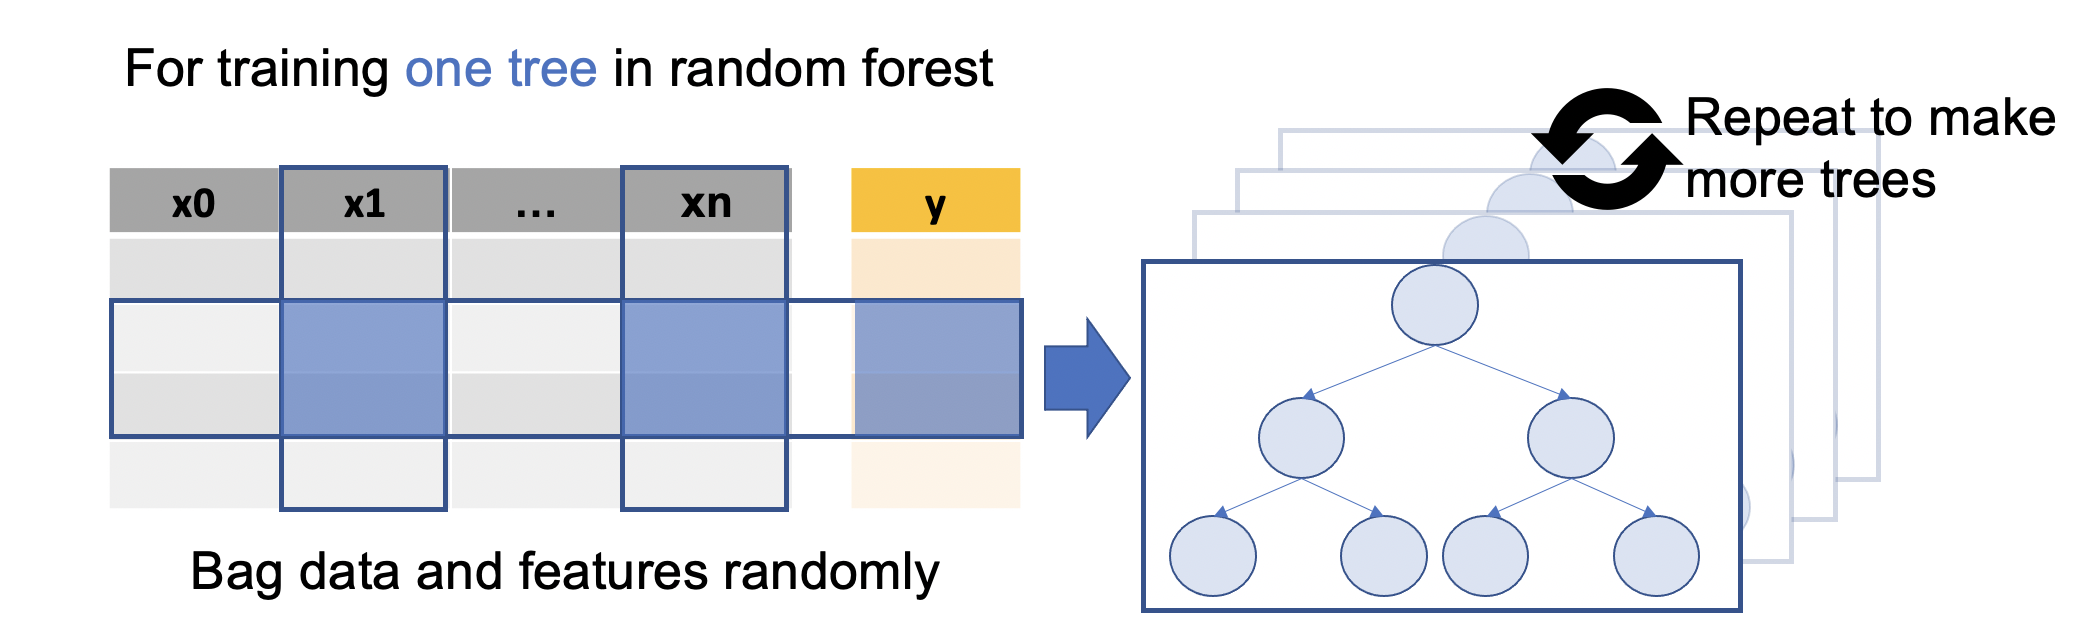

- <font size=4> __Additional Hyperparameters__: Forest size, bagging sizes
    
- <font size=4> __Training__: Repeat decision tree training for ensemble
    
- <font size=4> __Additional Pros__: Significantly reduces model overfitting.
    
- <font size=4> __Additional Cons__: can be expensive to train

In [19]:
model = sklearn.ensemble.RandomForestRegressor()
score, co2 = train_test_track_carbon(model, classification=False)
print(f'MAE: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 10:24:27] [setup] RAM Tracking...
[codecarbon INFO @ 10:24:27] [setup] GPU Tracking...
[codecarbon INFO @ 10:24:27] No GPU found.
[codecarbon INFO @ 10:24:27] [setup] CPU Tracking...
[codecarbon WARNING @ 10:24:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:24:28] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:28] >>> Tracker's metadata:
[codecarbon INFO @ 10:24:28]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:24:28]   Python version: 3.9.15
[codecarbon INFO @ 10:24:28]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:24:28]   CPU count: 16
[codecarbon INFO @ 10:24:28]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:28]   GPU count: None
[codecarbon INFO @ 10:24:28]   GPU model: None
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_31497/2728076885.py:16: DataConversionWarning: A column-vector y was pa

MAE: 0.006693242317959216, co2 [kg]: 8.417832680193753e-07


### B. _Exercise_: Cost of Random Forest

<font size=4> I mentioned that RFs can be expensive to train - consider the following three hyperparameters: 
    
<font size=4> - `n_estimators`: this indicates the number of different decision tree used in the ensemble

<font size=4> - `max_depth`: this indicates the maximum branch distance from the root to the final label decision, eg. the height of the tree.
    
<font size=4> - `max_features`: this indicates the maximum number of features to threshold at the beanches, eg. if it is 1, then only one feature will be used to make the branch decision.
    
<font size=4> __Choose one__ of these hyperparameters to conduct a study on. Test out different values of the hyperparameter, and record the carbon cost for training and prediction. Ensure someone at your table is doing each hyperparameter. How does the hyperparameter effect the carbon cost? A plot may be helpful.

In [20]:
co2s = []
n_estimators_list = [5, 10, 100, 1000]
for n_estimators in n_estimators_list:
    model = sklearn.ensemble.RandomForestRegressor(n_estimators=n_estimators)
    _, co2 = train_test_track_carbon(model, classification=False)
    co2s.append(co2)

[codecarbon INFO @ 10:24:34] [setup] RAM Tracking...
[codecarbon INFO @ 10:24:34] [setup] GPU Tracking...
[codecarbon INFO @ 10:24:34] No GPU found.
[codecarbon INFO @ 10:24:34] [setup] CPU Tracking...
[codecarbon WARNING @ 10:24:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:24:36] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:36] >>> Tracker's metadata:
[codecarbon INFO @ 10:24:36]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:24:36]   Python version: 3.9.15
[codecarbon INFO @ 10:24:36]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:24:36]   CPU count: 16
[codecarbon INFO @ 10:24:36]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:36]   GPU count: None
[codecarbon INFO @ 10:24:36]   GPU model: None
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_31497/2728076885.py:16: DataConversionWarning: A column-vector y was pa

Text(0, 0.5, 'Carbon [kg]')

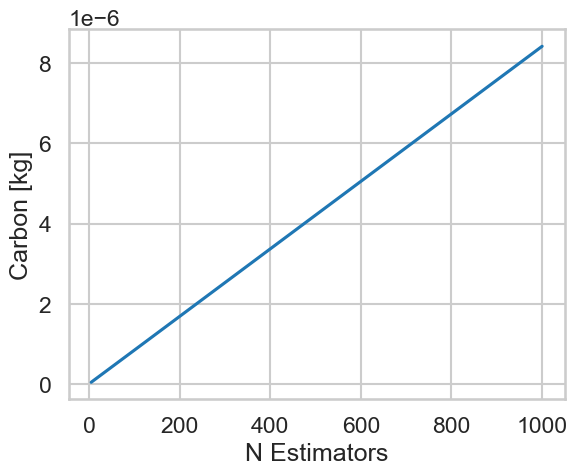

In [21]:
fig, ax = plt.subplots()
ax.plot(n_estimators_list, co2s)
ax.set_xlabel('N Estimators')
ax.set_ylabel('Carbon [kg]')

In [22]:
co2s = []
max_depth_list = [1, 2, 3, 4, 5, 10, 100, 1000]
for max_depth in max_depth_list:
    model = sklearn.ensemble.RandomForestRegressor(max_depth=max_depth)
    _, co2 = train_test_track_carbon(model, classification=False)
    co2s.append(co2)

[codecarbon INFO @ 10:24:56] [setup] RAM Tracking...
[codecarbon INFO @ 10:24:56] [setup] GPU Tracking...
[codecarbon INFO @ 10:24:56] No GPU found.
[codecarbon INFO @ 10:24:56] [setup] CPU Tracking...
[codecarbon WARNING @ 10:24:56] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:24:58] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:58] >>> Tracker's metadata:
[codecarbon INFO @ 10:24:58]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:24:58]   Python version: 3.9.15
[codecarbon INFO @ 10:24:58]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:24:58]   CPU count: 16
[codecarbon INFO @ 10:24:58]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:24:58]   GPU count: None
[codecarbon INFO @ 10:24:58]   GPU model: None
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_31497/2728076885.py:16: DataConversionWarning: A column-vector y was pa

<font size=4>10 times the models in the ensemble means 10 times the cost

Text(0, 0.5, 'Carbon [kg]')

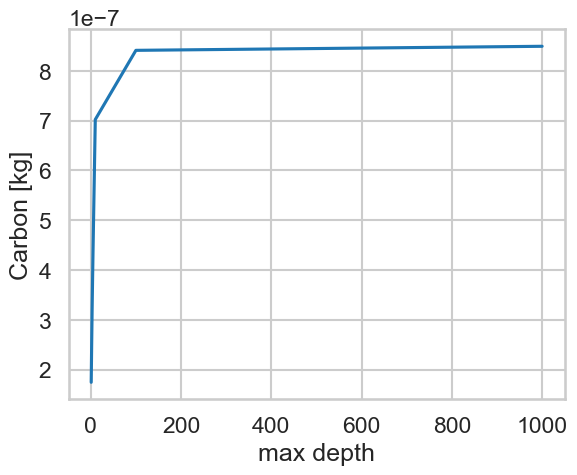

In [23]:
fig, ax = plt.subplots()
ax.plot(max_depth_list, co2s)
ax.set_xlabel('max depth')
ax.set_ylabel('Carbon [kg]')

font size=4>The cost plateaus - why is that? 

In [24]:
co2s = []
max_feats_list = [1, 2, 3]
for max_feats in max_feats_list:
    model = sklearn.ensemble.RandomForestRegressor(max_features=max_feats)
    _, co2 = train_test_track_carbon(model, classification=False)
    co2s.append(co2)

[codecarbon INFO @ 10:25:35] [setup] RAM Tracking...
[codecarbon INFO @ 10:25:35] [setup] GPU Tracking...
[codecarbon INFO @ 10:25:35] No GPU found.
[codecarbon INFO @ 10:25:35] [setup] CPU Tracking...
[codecarbon WARNING @ 10:25:35] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:25:36] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:25:36] >>> Tracker's metadata:
[codecarbon INFO @ 10:25:36]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:25:36]   Python version: 3.9.15
[codecarbon INFO @ 10:25:36]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:25:36]   CPU count: 16
[codecarbon INFO @ 10:25:36]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:25:36]   GPU count: None
[codecarbon INFO @ 10:25:36]   GPU model: None
/var/folders/9j/1f7mt18d2pqcwws6hwdx7_kr0000gn/T/ipykernel_31497/2728076885.py:16: DataConversionWarning: A column-vector y was pa

Text(0, 0.5, 'Carbon [kg]')

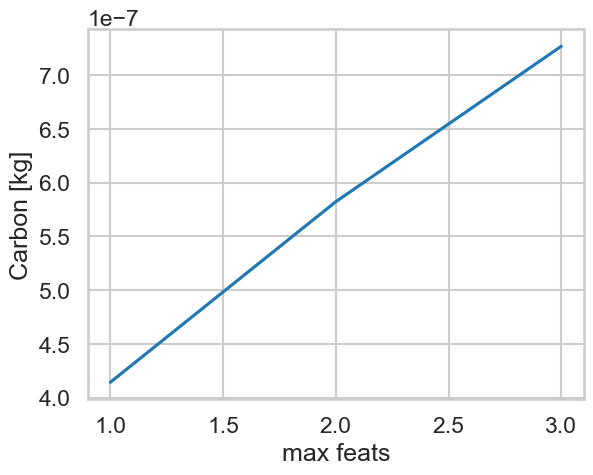

In [25]:
fig, ax = plt.subplots()
ax.plot(max_feats_list, co2s)
ax.set_xlabel('max feats')
ax.set_ylabel('Carbon [kg]')

<font size=4>Also a linear relationship.

## 4. Kernel Methods

<font size=4>You will often see the "Kernel Trick" used in many ML models. This principle essentially extracts an __abstract higher dimensional feature space__ from the original features.

<font size=4>Consider a binary classification dataset with two features $x_0$ and $x_1$:

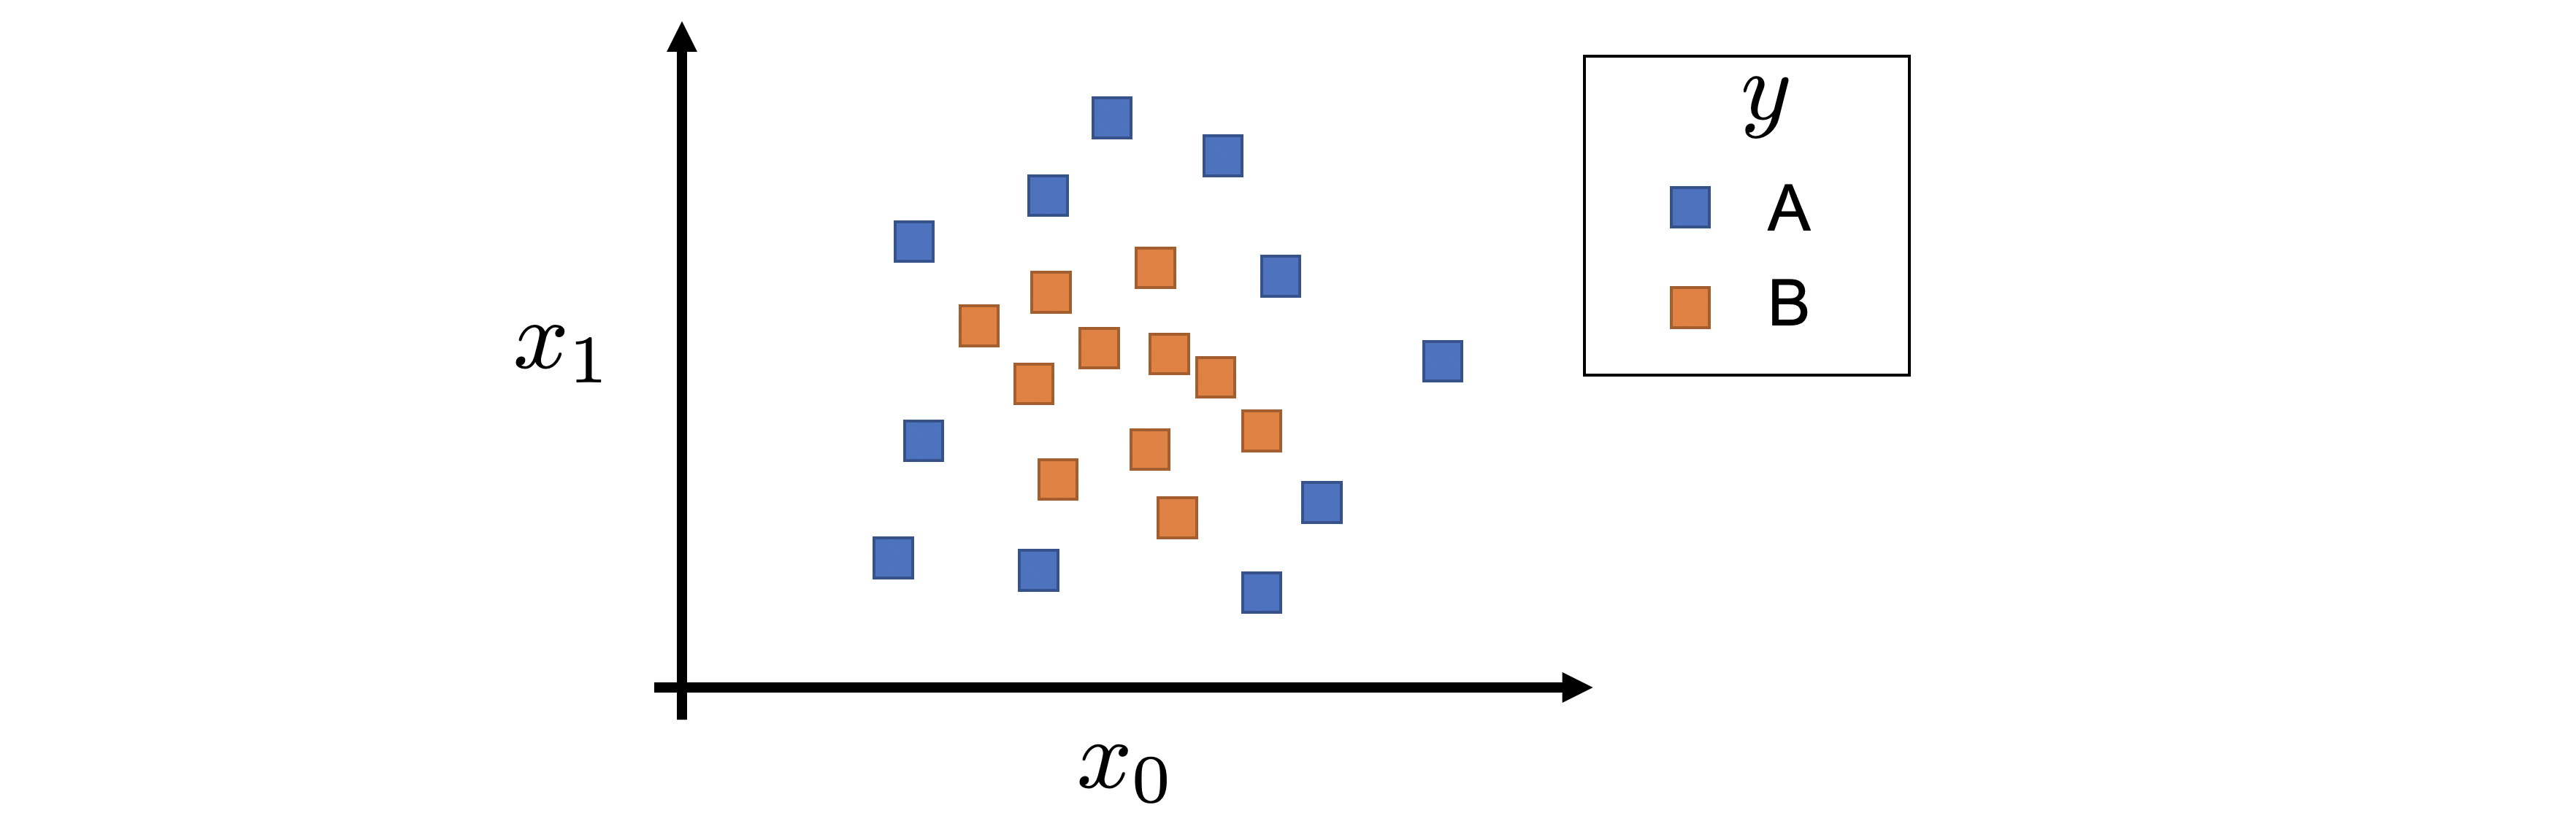

<font size=4>There is cleary a relationship between the target $y$ and the two features, but a linear decision boundary would not be effective in determining $y$. __What if we transformed the features $x_0$ and $x_1$ into three dimensions using a function__?

<font size=4>$$\Phi(X) = \Phi(x_0, x_1) = [x_0, x_1, \phi]$$

<font size=4>Our estimator is then just:
    
<font size=4>$$\hat{y}=\hat{f}(\Phi(X))$$

<font size=4>And our feature space is now 3 dimensions instead of two. __Consider if the third dimension we just made to be equal to a cone?__

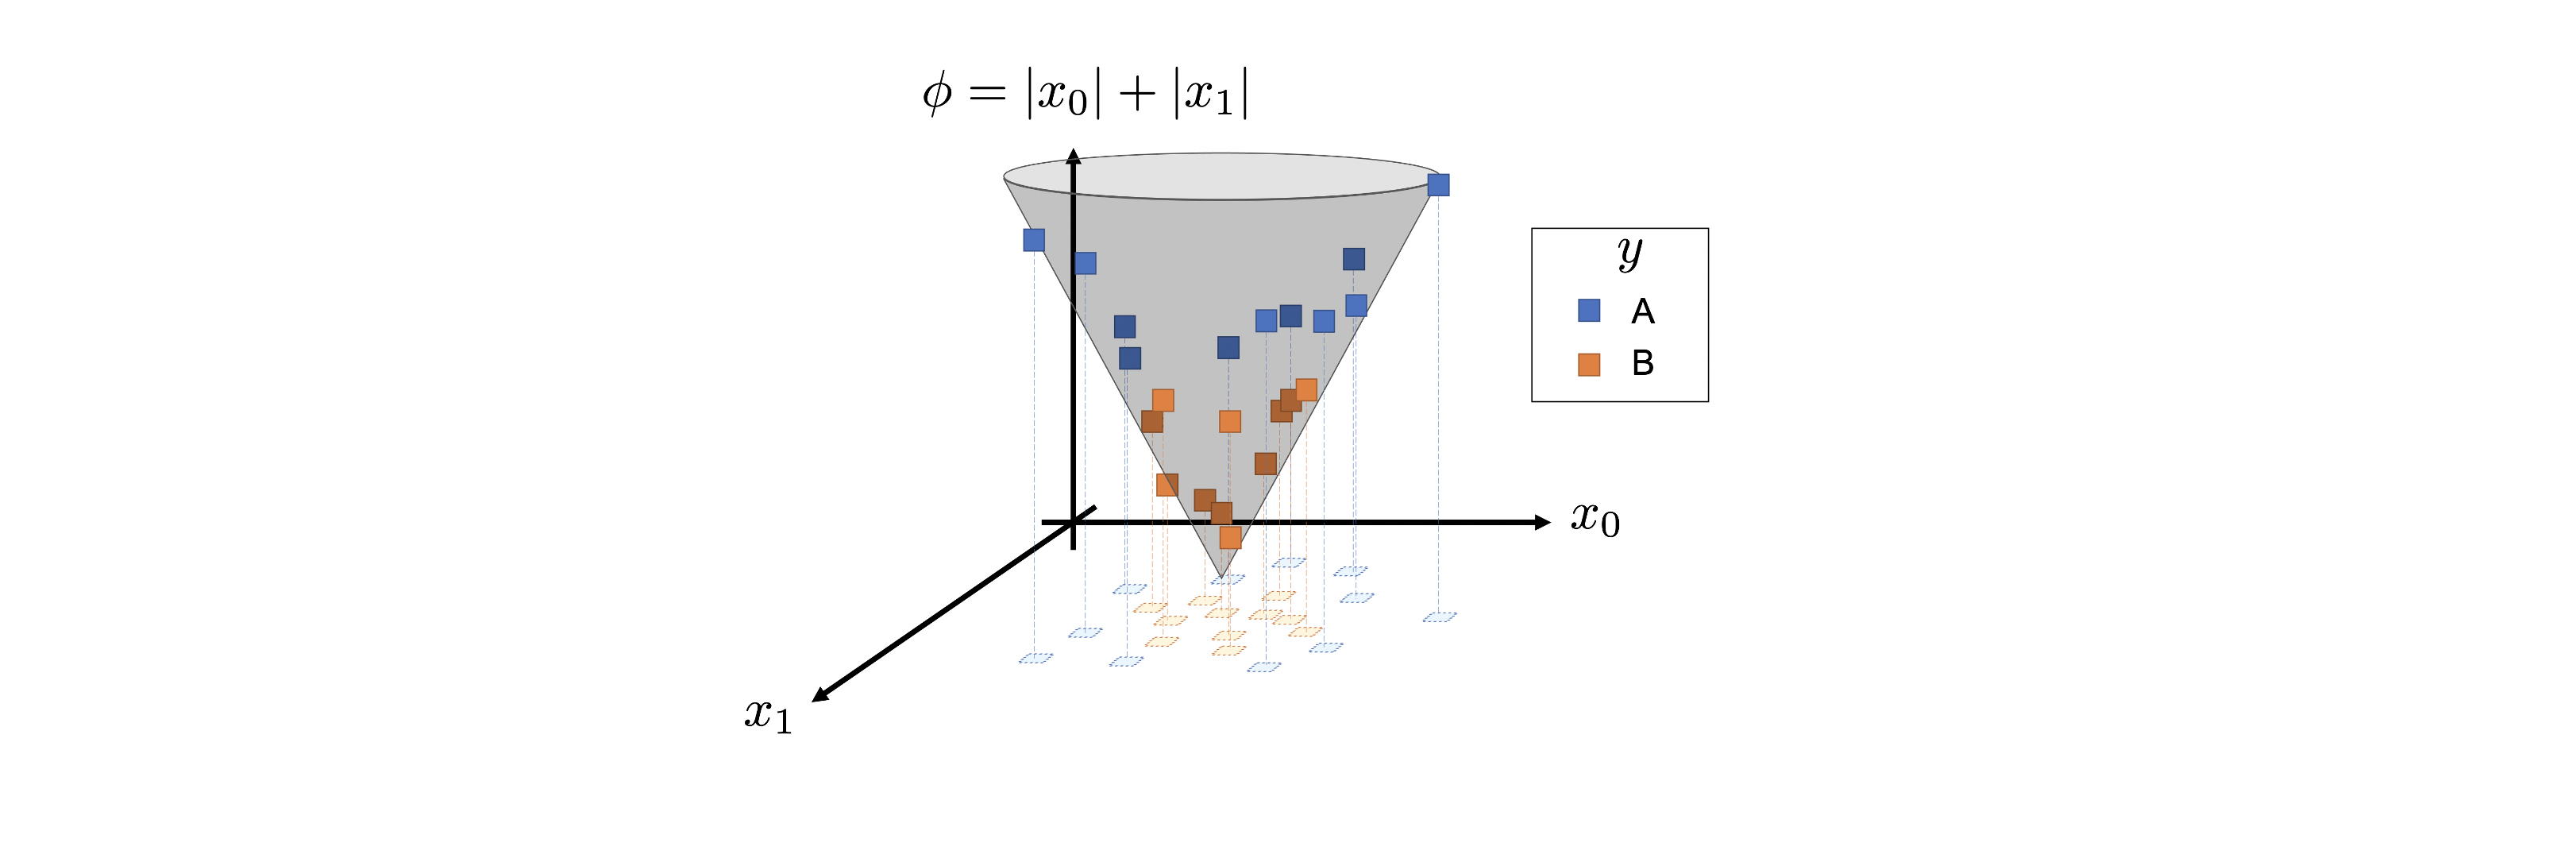

<font size=5><center>After we apply the function, $\Phi(X)\in\mathbb{R}^2\rightarrow\mathbb{R}^3$, __we can easily draw a linear plane to differentiate the classes in three dimensions__.

***

<font size=5><center>But we had to make a very specific choice of the function $\Phi$ :(

<font size=4>The Kernel Trick allows us to apply a function __without knowing the form of the function__, thus the higher-dimensional feature space we create is part of the ML problem. The trick is based on the following, where $k$ is a kernel function (it has some constraints, out of scope):

$$\Phi(X_1)\cdot\Phi(X_2)=k(X_1,X_2)$$

<font size=4>In words - we can represent the __dot product of an unkown high dimensional mapping of features between two examples__ as a function that we know. If we do this for out whole dataset, eg $X_0,....X_N$, the resulting square matrix is the __kernel matrix__ $K$.

<font size=4>What use is the kernel matrix? Well, the __kernel matrix is equal to the covariance matrix of the high dimensional space__!

<font size=4>$$K = \Phi(X)^T\Phi(X)$$

<font size=5><center>Both training and prediction of a variety of architectures can be broken down to functions of the kernel matrix, without ever knowing $\Phi$.

### A. Kernel Ridge Regression

<font size=4>Conducts linear ridge regression on a high dimensional kernel space.

<font size=4>[`sklearn.kernel_ridge.KernelRidge`](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)

- <font size=4> __Hyperparameters__: Features used, kernel used, regularization term
    
- <font size=4> __Training__: Analytical Kernel Least Squares
    
- <font size=4> __Parameters__: Weights for kernel features and intercept
    
- <font size=4> __Pros__: Very flexible, handles data where features are correlated very well
    
- <font size=4> __Cons__: Prohibitively expensive to train for large datasets, sensitive to overfitting to noise

In [26]:
model = sklearn.kernel_ridge.KernelRidge()
score, co2 = train_test_track_carbon(model, classification=False)
print(f'MAE: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 10:25:47] [setup] RAM Tracking...
[codecarbon INFO @ 10:25:47] [setup] GPU Tracking...
[codecarbon INFO @ 10:25:47] No GPU found.
[codecarbon INFO @ 10:25:47] [setup] CPU Tracking...
[codecarbon WARNING @ 10:25:47] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:25:49] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:25:49] >>> Tracker's metadata:
[codecarbon INFO @ 10:25:49]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:25:49]   Python version: 3.9.15
[codecarbon INFO @ 10:25:49]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:25:49]   CPU count: 16
[codecarbon INFO @ 10:25:49]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:25:49]   GPU count: None
[codecarbon INFO @ 10:25:49]   GPU model: None
[codecarbon INFO @ 10:25:49] Energy consumed for RAM : 0.000001 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:25:49] Energy consume

MAE: 1.8767887503283862, co2 [kg]: 7.624065300233543e-07


### B. _Poll_: Kernel regression

<font size=4>Why wouldn't we want to do Kernel MLR, and instead do it to ridge regression?
    
<font size=4> - The Kernel trick doesn't work for basic MLR

<font size=4> - The Kernel trick increases the liklihood of overfitting
    
<font size=4> - The Kernel trick makes MLR harder to interpret

### C. Support Vector Machine

<font size=4>Draws a hyperplane to maximally seperate data in a new kernel space. Classification originally, but extended for regression cases.

<font size=4>[`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
    
<font size=4>[`sklearn.svm.SVR`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)

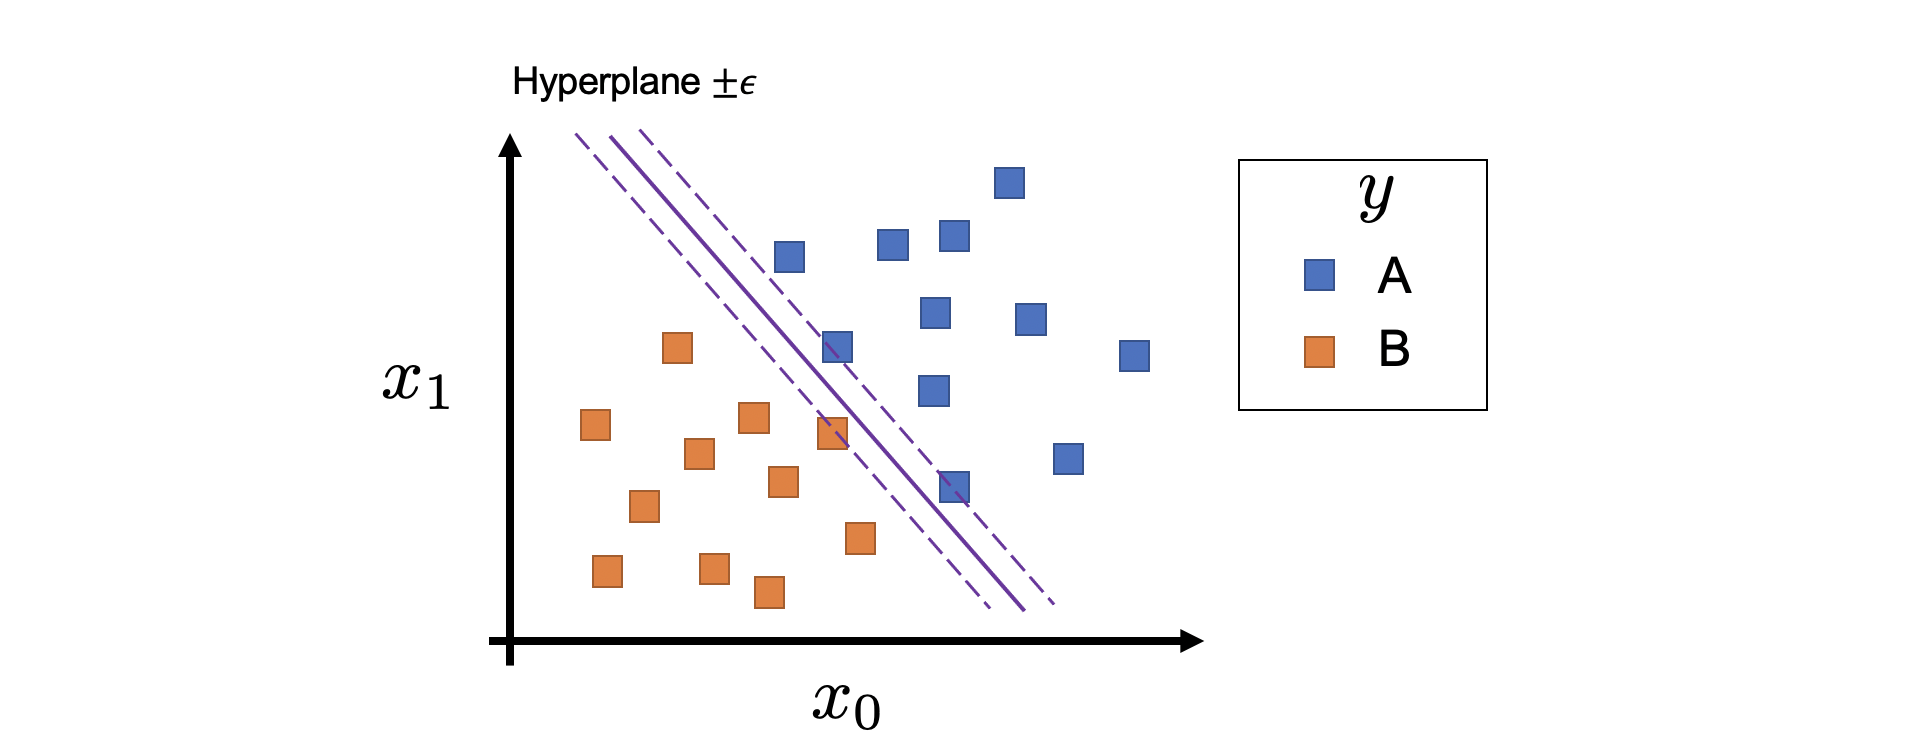

- <font size=4> __Hyperparameters__: Features used, kernel used, type of distance, $\epsilon$
    
- <font size=4> __Training__: Convex optimization of hyperplane to maximally seperate data
    
- <font size=4> __Parameters__: Hyperplane
    
- <font size=4> __Pros__: Very flexible, effective for high dimensions (many features)
    
- <font size=4> __Cons__: Prohibitively expensive to train for large datasets, sensitive to overfitting to noise

In [27]:
model = sklearn.svm.SVC()
score, co2 = train_test_track_carbon(model, classification=True)
print(f'Accuracy: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 10:25:51] [setup] RAM Tracking...
[codecarbon INFO @ 10:25:51] [setup] GPU Tracking...
[codecarbon INFO @ 10:25:51] No GPU found.
[codecarbon INFO @ 10:25:51] [setup] CPU Tracking...
[codecarbon WARNING @ 10:25:51] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:25:53] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:25:53] >>> Tracker's metadata:
[codecarbon INFO @ 10:25:53]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:25:53]   Python version: 3.9.15
[codecarbon INFO @ 10:25:53]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:25:53]   CPU count: 16
[codecarbon INFO @ 10:25:53]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:25:53]   GPU count: None
[codecarbon INFO @ 10:25:53]   GPU model: None
/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: 

Accuracy: 0.9826666666666667, co2 [kg]: 1.1278789864281798e-07


### D. Gaussian Processes

<font size=4>Uses Baye's theorem to model a __probability over functions__ in kernel space. Also outputs an estimation of probability. Can be used for classification and regression.

<font size=4>[`sklearn.gaussian_process.GaussianProcessRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)
    
<font size=4>[`sklearn.gaussian_process.GaussianProcessClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier)

<font size=4>This one is quite hard to grasp and to explain, but at a high level:
    
1. <font size=4> Assume  "Prior" distribution  of functions. We assume a normal distribution. Sampling __from this prior can yield an infinite number of functions that can look like anything distributed around 0__.

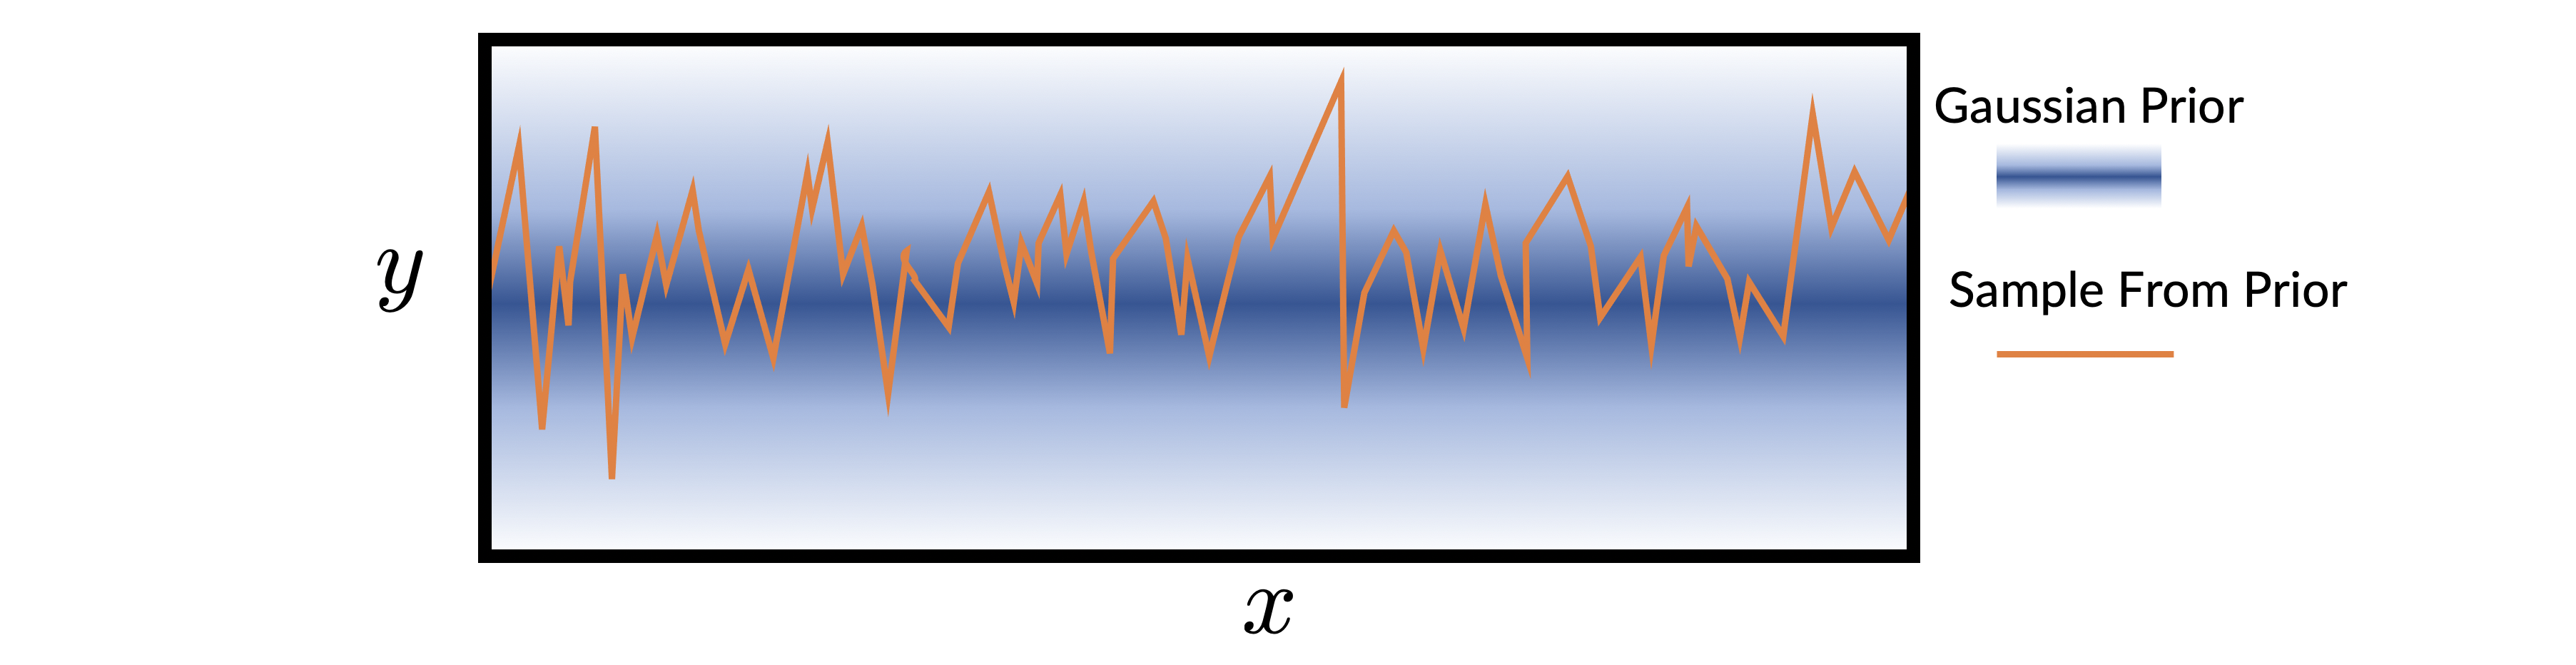

2. <font size=4> Apply a kernel $k(x, x')$ to smooth the prior. __For all kernels the closer in $x$ you points are, the smaller $k$__ which causes the smoothing.

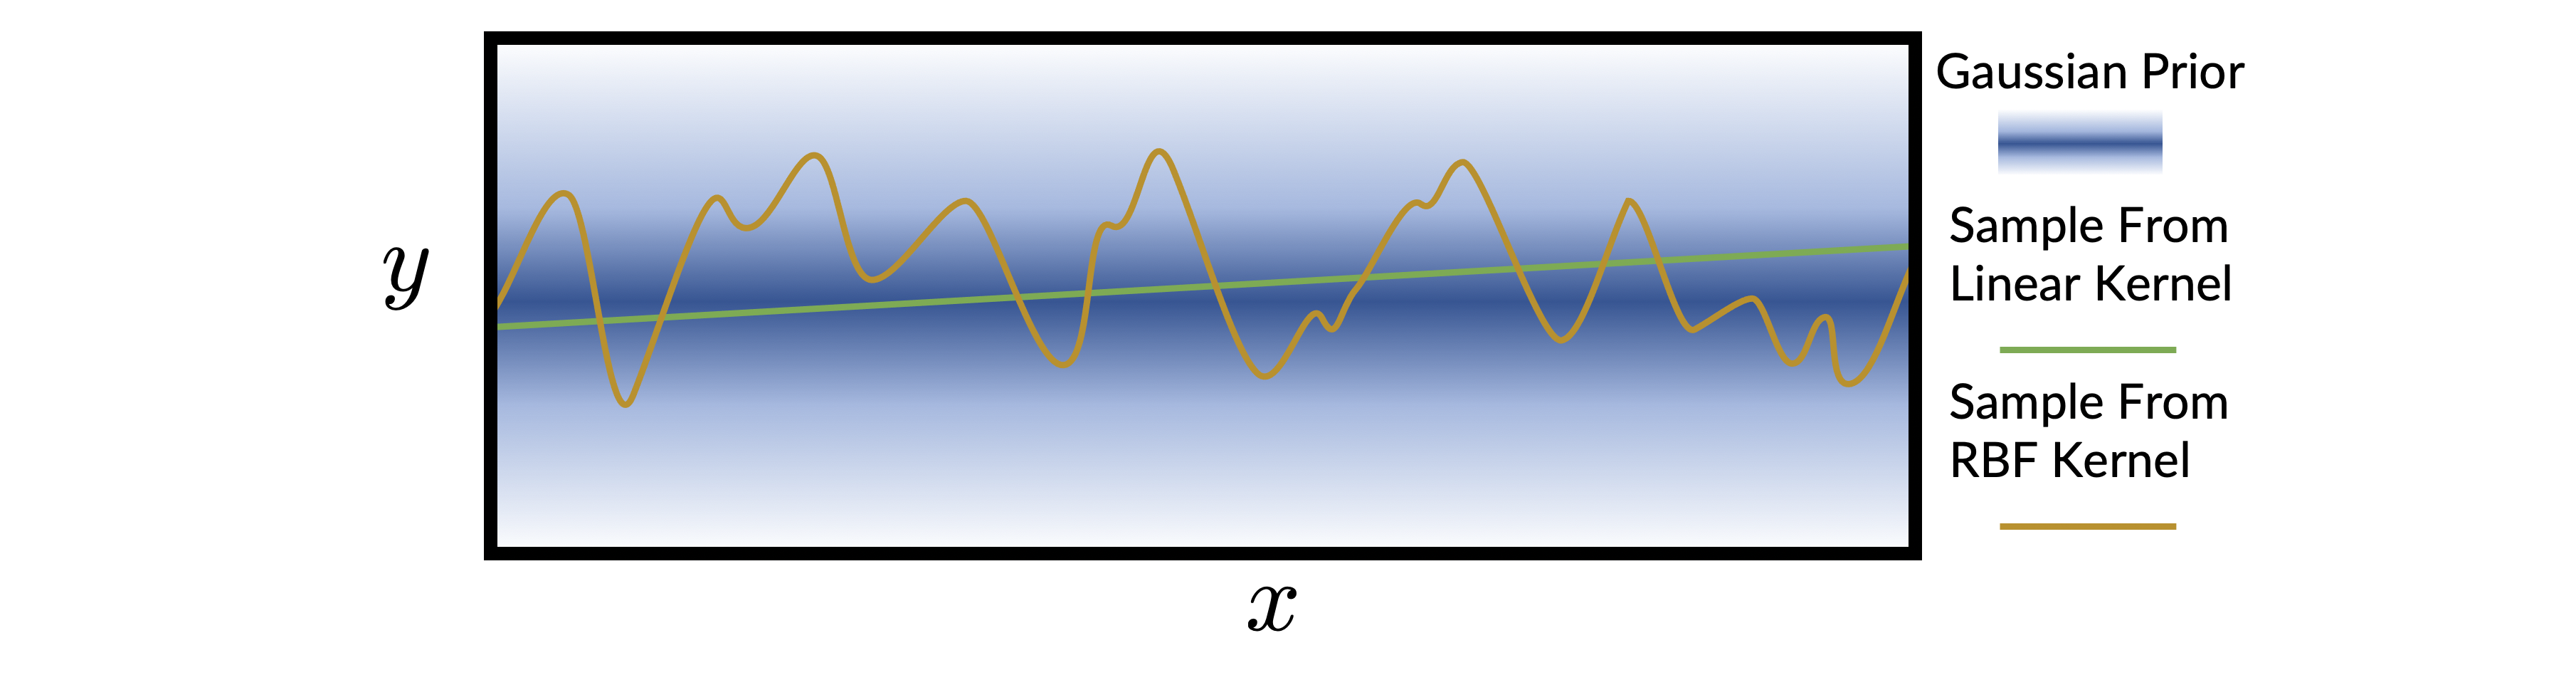

3. <font size=4> Add data and create "posterior distribution" according to [Bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)

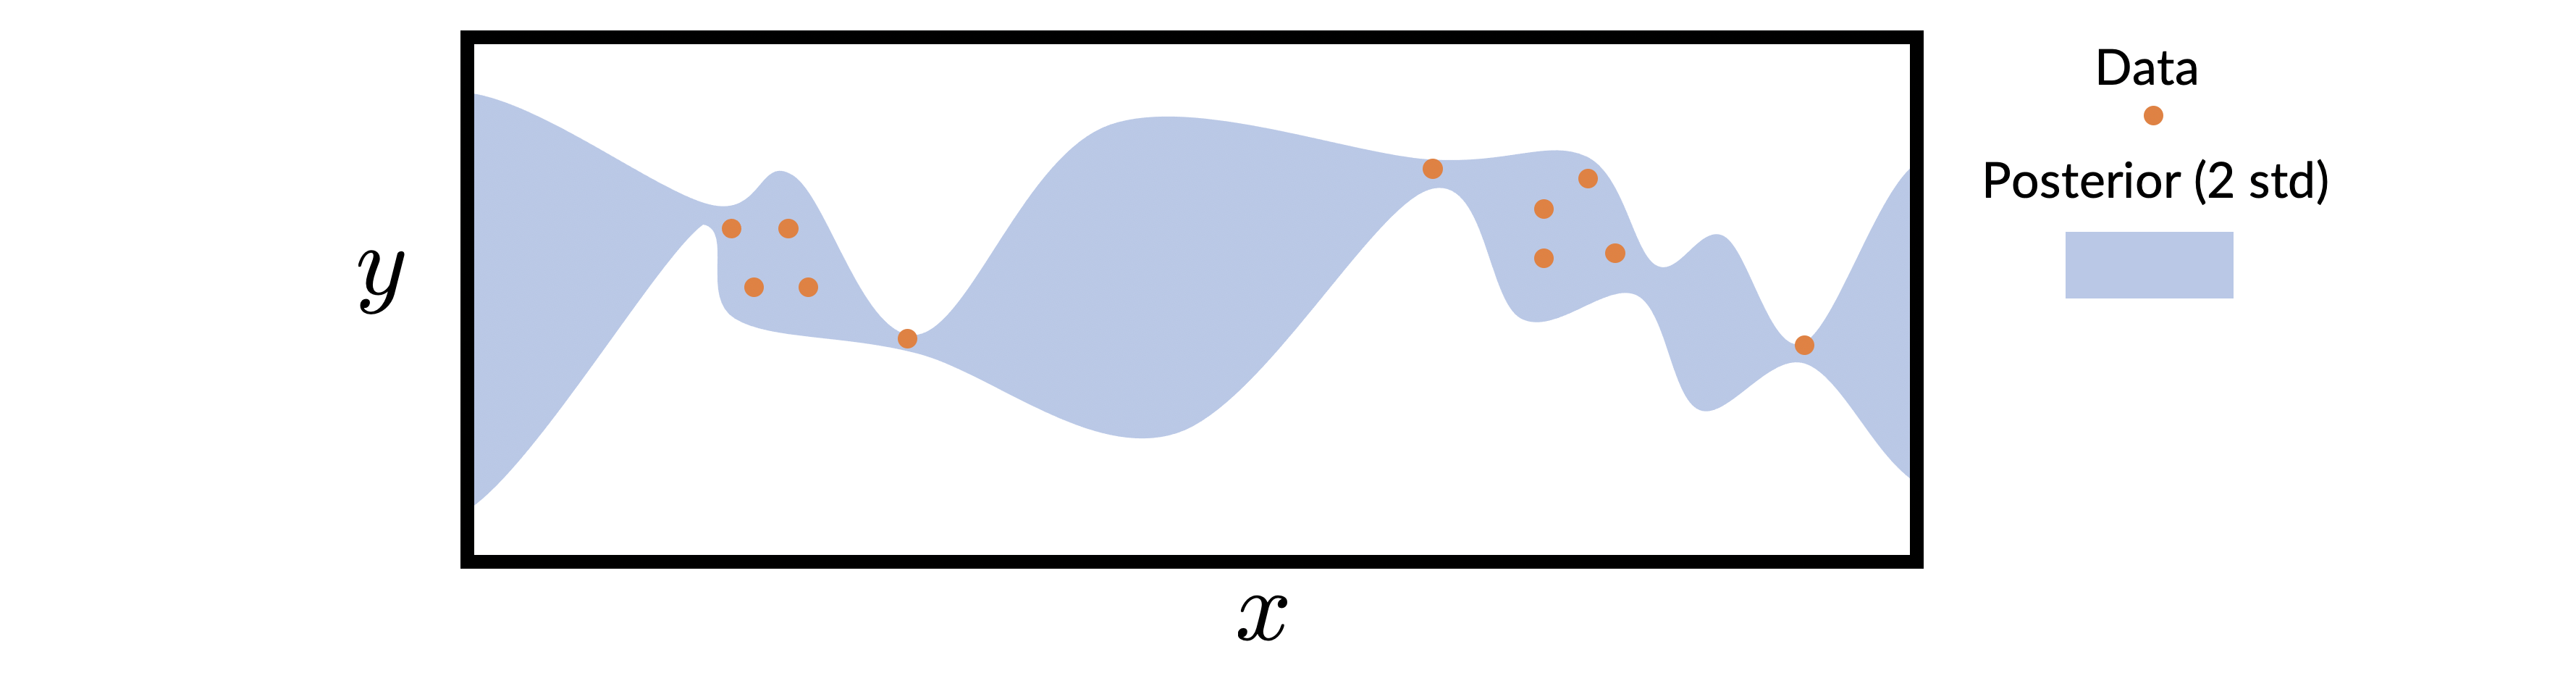

3. <font size=4> Sample from Posterior many times, take means and std.

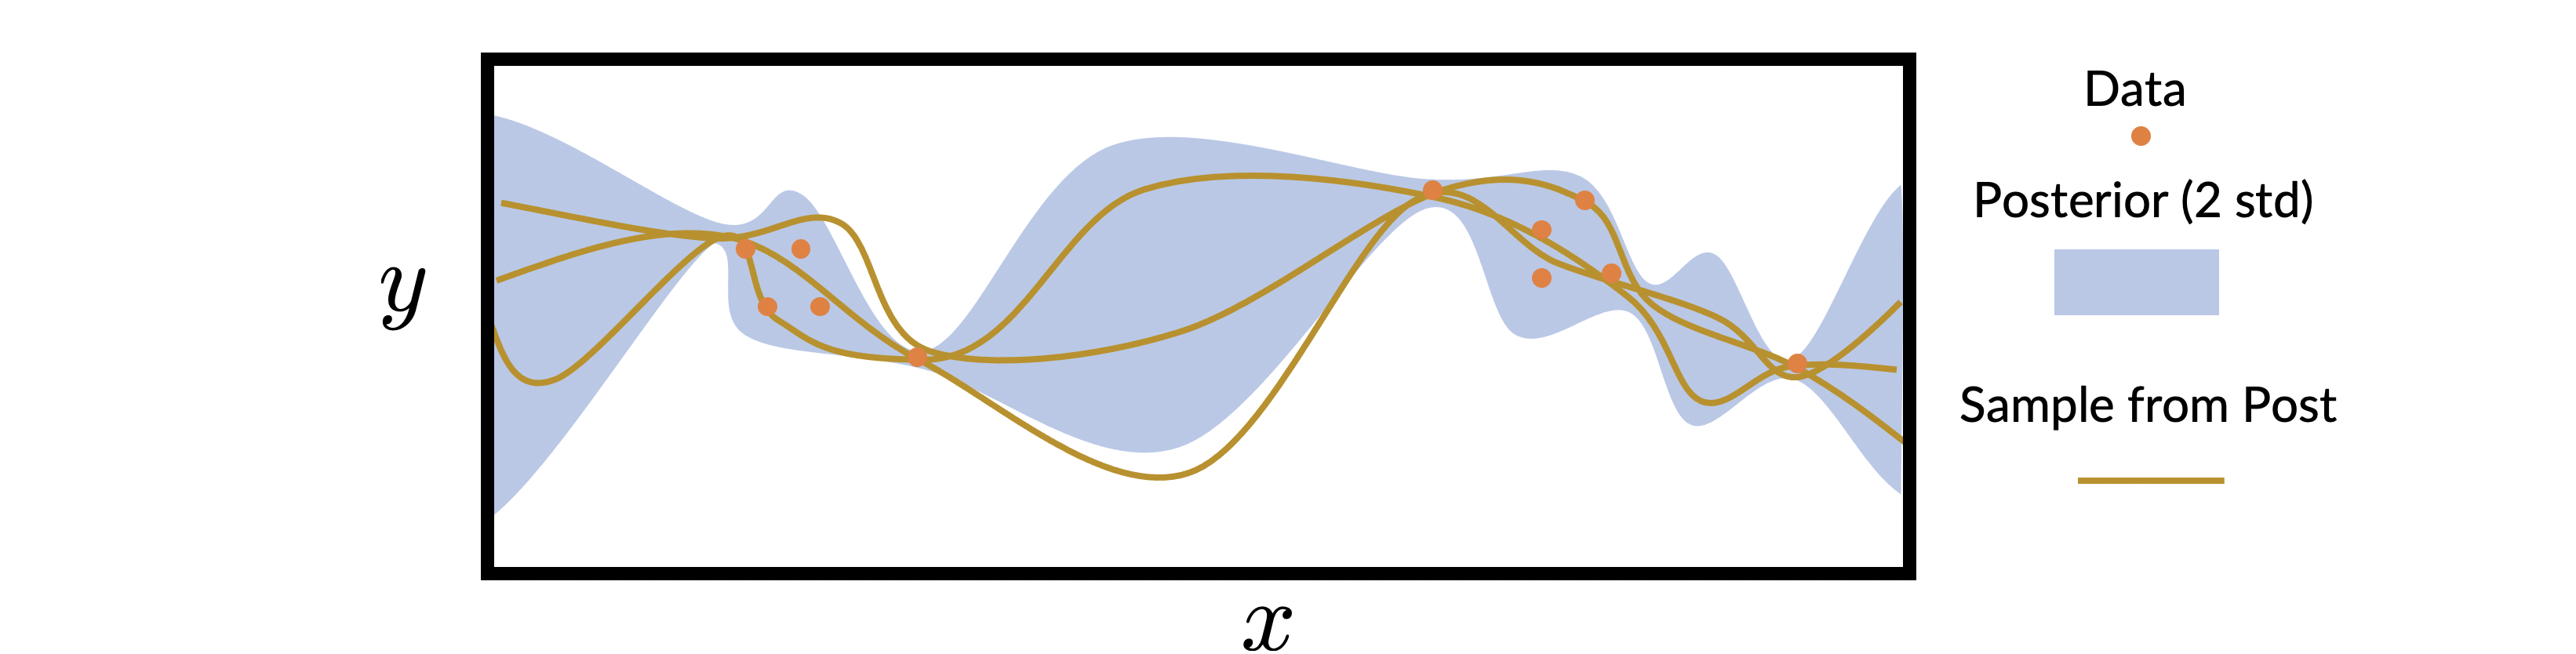

- <font size=4> __Hyperparameters__: Features used, kernel used, parameters of kernel
    
- <font size=4> __Training__: Compute probability over functions using Bayes's theorem, sample
    
- <font size=4> __Parameters__: Posterior distribution
    
- <font size=4> __Pros__: Very flexible, gives a measure of probability or uncertainty
    
- <font size=4> __Cons__: Prohibitively expensive to train for large datasets or high dimensional features, very sensitive to kernel hyperparameters.

In [28]:
model = sklearn.gaussian_process.GaussianProcessRegressor(alpha=1e-2)
score, co2 = train_test_track_carbon(model, classification=False)
print(f'MAE: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 10:25:55] [setup] RAM Tracking...
[codecarbon INFO @ 10:25:55] [setup] GPU Tracking...
[codecarbon INFO @ 10:25:55] No GPU found.
[codecarbon INFO @ 10:25:55] [setup] CPU Tracking...
[codecarbon WARNING @ 10:25:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:25:56] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:25:56] >>> Tracker's metadata:
[codecarbon INFO @ 10:25:56]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:25:56]   Python version: 3.9.15
[codecarbon INFO @ 10:25:56]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:25:56]   CPU count: 16
[codecarbon INFO @ 10:25:56]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:25:56]   GPU count: None
[codecarbon INFO @ 10:25:56]   GPU model: None
[codecarbon INFO @ 10:26:01] Energy consumed for RAM : 0.000002 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:26:01] Energy consume

MAE: 0.010654419971644348, co2 [kg]: 1.6420463598963417e-06


<font size=4>We also get bonus predictions of uncertainty:

In [29]:
pred_means, pred_stds = model.predict(test_X, return_std=True)

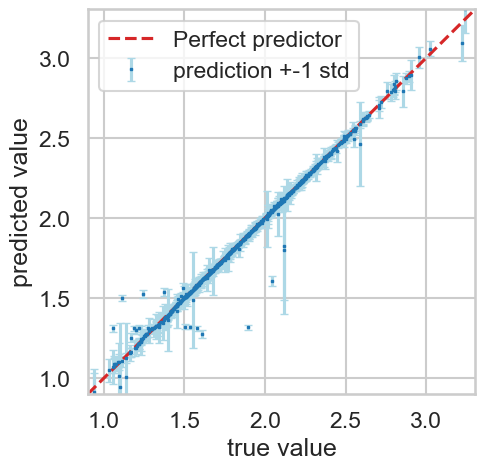

In [30]:
fig, ax = plt.subplots(figsize=(5,5)) 
min_y = min([test_y_regr.min(), pred_means.min()])
max_y = max([test_y_regr.max(), pred_means.max()])

ax.errorbar(test_y_regr, pred_means, yerr=pred_stds, fmt='s', ms=2, capsize=3, ecolor='lightblue', label='prediction +-1 std')
ax.plot([min_y, max_y], [min_y, max_y], ls='--', c='tab:red', label='Perfect predictor')
ax.set_xlim((min_y, max_y))
ax.set_ylim((min_y, max_y))
ax.set_xlabel('true value')
ax.set_ylabel('predicted value')
ax.legend()

## 5. Boosting

<font size=4>Boosting is the principle of combining many week learners (eg high bias) to create a more performative one. __"Gradient boosting" models the error of previous predictions, and the results are added together__. It most most easily understood for trees:

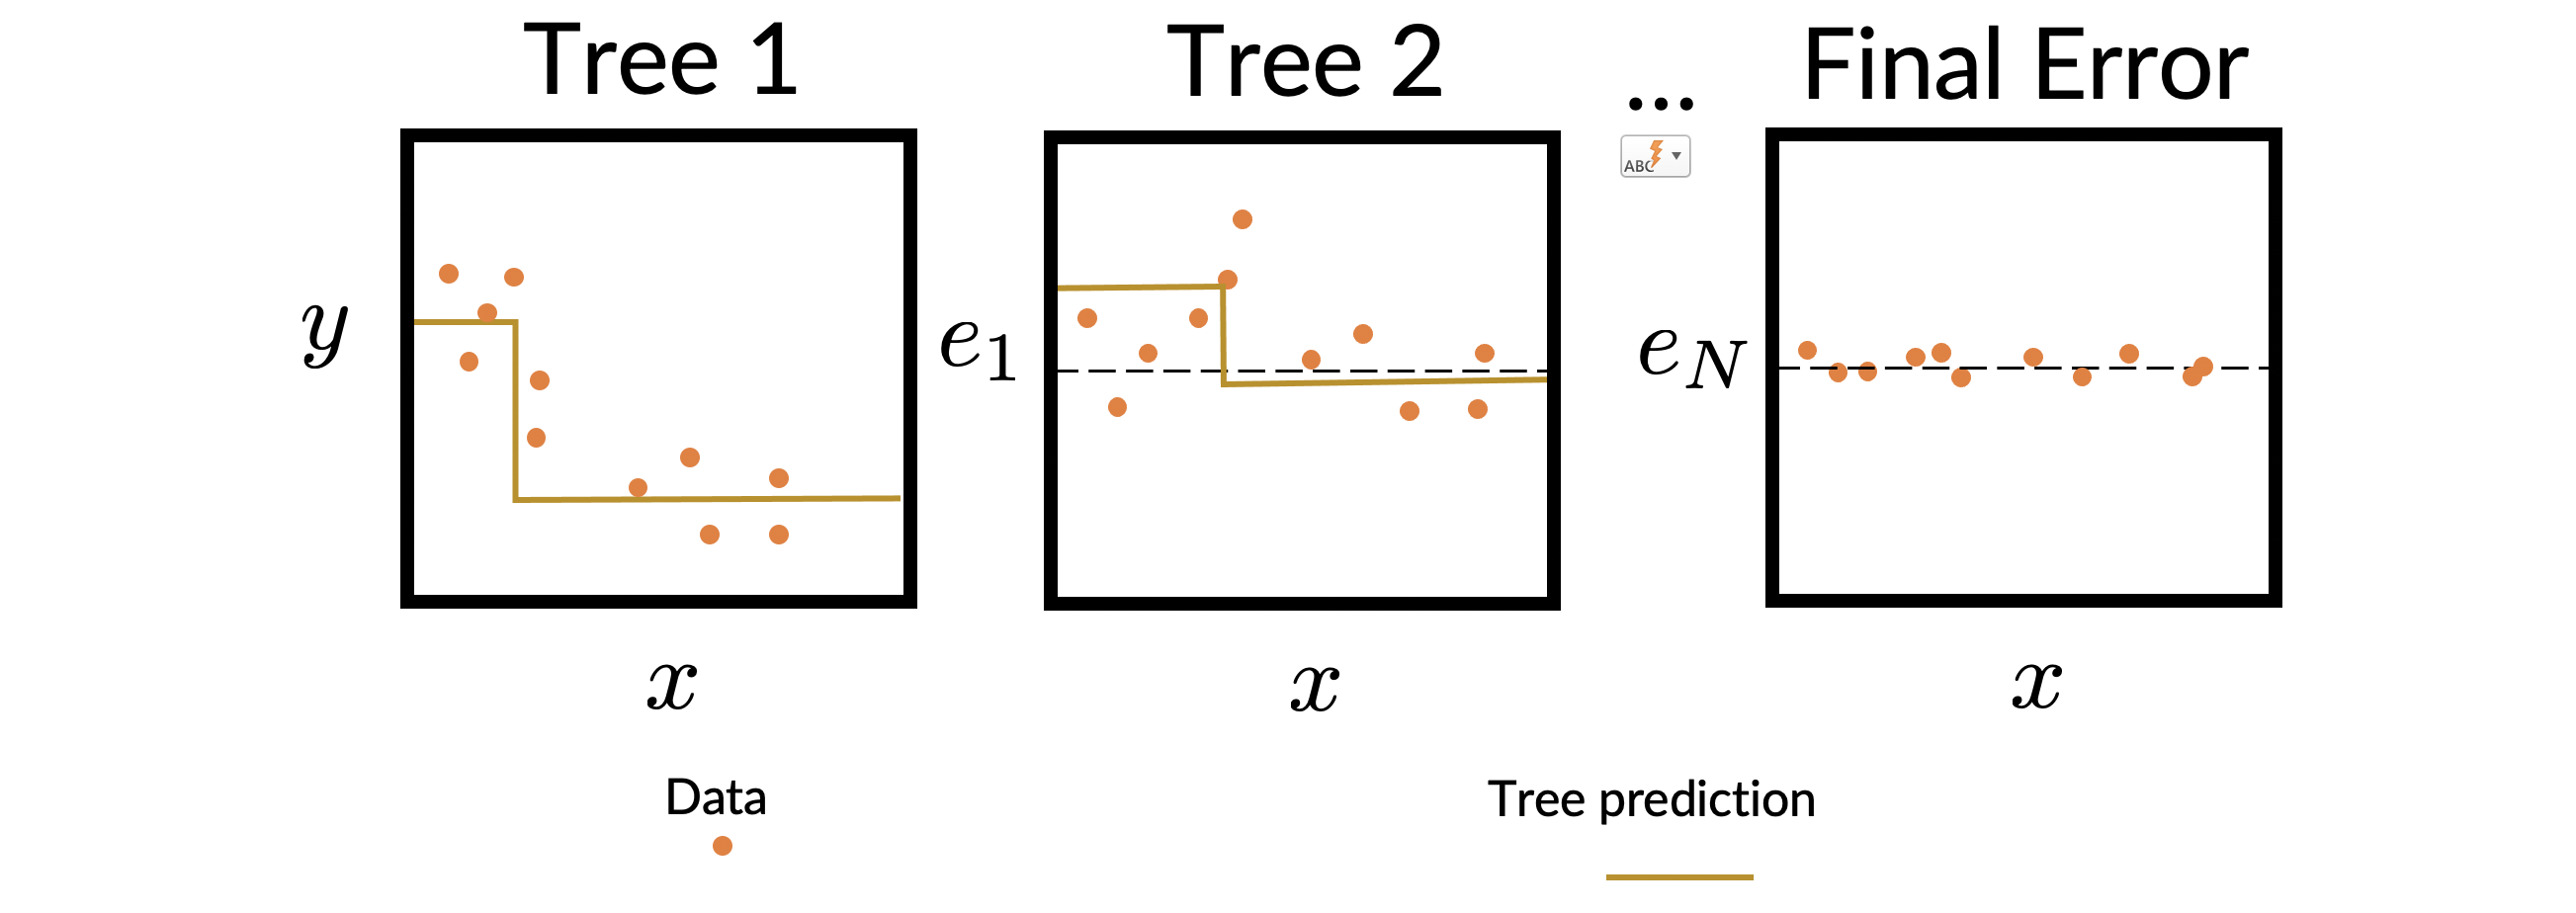

### A. _Exercise_: One round of boosting

<font size=4>Boosting is typically used for decision trees. To make its effect most pronounced, we will use __shallow decision trees__ by limitting the depth to 3.

1. <font size=4> Train a decision tree on the dev data with `max_depth=3`. Report its test-set MSE
    
2. <font size=4> Compute the __first model's error for each datapoint on the dev set__, and use this error as the target for a new decision tree with `max_depth=3`. __Subtract the predictions of error from the first model prediction on the test set together to report the boosted model's MSE__. How does it compare to the one decision tree alone?

In [31]:
# train the first model
model1 = sklearn.tree.DecisionTreeRegressor(max_depth=3)
model1.fit(dev_X, dev_y_regr)

# compute error on dev set, this is the new target
model1_dev_error = model1.predict(dev_X).reshape(-1,1) - dev_y_regr

In [32]:
# report performance of first model
model1_preds = model1.predict(test_X).reshape(-1,1)
print(f"Test MSE of first model: {sklearn.metrics.mean_squared_error(test_y_regr, model1_preds)}")

Test MSE of first model: 0.014049379588917589


In [33]:
# train first boosting of the model using the first model error as a target
model2 = sklearn.tree.DecisionTreeRegressor(max_depth=3)
model2.fit(dev_X, model1_dev_error)

# predict error of model1 on the test set
model2_preds = model2.predict(test_X).reshape(-1,1)

In [34]:
# report MSE of boosted model
boosted_preds = model1_preds - model2_preds
print(f"Test MSE of boosted model: {sklearn.metrics.mean_squared_error(test_y_regr, boosted_preds)}")

Test MSE of boosted model: 0.00595093370823386


<font size=4> `sklearn` provides is this functionality without having to do each round of boosting manually:

In [35]:
boosted_model = sklearn.ensemble.GradientBoostingRegressor(max_depth=3, n_estimators=100)

boosted_model.fit(dev_X, dev_y_regr)
boosted_preds = boosted_model.predict(test_X).reshape(-1,1)
print(f"Test MSE of boosted model: {sklearn.metrics.mean_squared_error(test_y_regr, boosted_preds)}")

/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test MSE of boosted model: 0.0015456760024822743


### B. XGBoost

<font size=4>What if we bagged decision trees (Random Forest) to decrease variance and also did gradient boosting to decrease the bias, would we create the perfect model? 
    
<font size=4> XGboost does all that an more, and the go-to solution in industry for simple$^*$ supervise machine learning applications. __XGBoost is almost always the top performing model for simple$^*$ supervised machine learning__ 
    
$^*$(when a moderate number of good features can be engineered, see next notebook!).

- <font size=4> __Hyperparameters__: Tree hyperparams, boosting hyperparams, bagging hyperparams, regularization strengths, and more...
    
- <font size=4> __Training__: Creation of large numbers of ensemle learners
    
- <font size=4> __Parameters__: Huge number of tree parameters
    
- <font size=4> __Pros__: Very flexible while also robust to overfitting, builtin hyperparameter optimization
    
- <font size=4> __Cons__: Prohibitively expensive to train for large datasets or high dimensional features, many hyperparameters to optimize to get best performance

In [36]:
model = xgboost.XGBRegressor()
score, co2 = train_test_track_carbon(model, classification=False)
print(f'MAE: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 10:26:03] [setup] RAM Tracking...
[codecarbon INFO @ 10:26:03] [setup] GPU Tracking...
[codecarbon INFO @ 10:26:03] No GPU found.
[codecarbon INFO @ 10:26:03] [setup] CPU Tracking...
[codecarbon WARNING @ 10:26:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:26:05] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:26:05] >>> Tracker's metadata:
[codecarbon INFO @ 10:26:05]   Platform system: macOS-13.1-x86_64-i386-64bit
[codecarbon INFO @ 10:26:05]   Python version: 3.9.15
[codecarbon INFO @ 10:26:05]   Available RAM : 16.000 GB
[codecarbon INFO @ 10:26:05]   CPU count: 16
[codecarbon INFO @ 10:26:05]   CPU model: Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz
[codecarbon INFO @ 10:26:05]   GPU count: None
[codecarbon INFO @ 10:26:05]   GPU model: None
[codecarbon INFO @ 10:26:06] Energy consumed for RAM : 0.000000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 10:26:06] Energy consume

MAE: 0.008720883035267097, co2 [kg]: 1.8597308720835014e-07


## Summary
- <font size=4> We introduced `codecarbon` a more rigorous way to track cost of computation than walltime
- <font size=4> We reviewed Linear models (basic regression, regularized regression, and logistic regression) and showed some pros and cons
- <font size=4> We introduced some new model types: Decision trees, random forests, and kernel methods such as kernel ridge regression, SVM, and gaussian processes
- <font size=4> We used Xgboost which is a __bagged, boosted decision tree ensemble taken to the extreme__ which is often the go-to when a set of good features can be produced

<font size=5>__A challenge for you__ - rerun this notebook but sample >> 5000 datapoints at the beginning, try 50000 or more. How does the carbon cost of these models change? Do any become unusable (takes too long to run?)